시청률+코스닥 파일의 위치는 Baseline과 같은 곳에

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 행 많이보기
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정
fm.get_fontconfig_fonts()

# fname 옵션을 사용하는 방법
font_location = 'C:\\WINDOWS\\Fonts\\\x7f\x7f\x7f\x7f.TTF' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

# 지수 표현 안보기

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## 기본 데이터

In [2]:
# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])

## 시청률 데이터

In [3]:
viewrate=pd.read_excel('./Data/시청률 데이터.xlsx',encoding='UTF-8',header=1)

## kosdaq(일별)

In [4]:
name='kosdaq19.01.01_20.08.17(일)'
d=pd.read_excel('./Data/'+name+'.xls',index_col='일자')
kosdaq_day=d.reset_index()

In [5]:
temp=[]
from datetime import datetime
for i in range(len(kosdaq_day)):
    temp.append(datetime.strptime(kosdaq_day['일자'][i], '%Y/%m/%d'))

kosdaq_day['일자_datetime']=temp

kosdaq_day['year']=kosdaq_day['일자_datetime'].apply(lambda x: x.year)
kosdaq_day['month']=kosdaq_day['일자_datetime'].apply(lambda x: x.month)
kosdaq_day['date']=kosdaq_day['일자_datetime'].apply(lambda x: x.day)

In [6]:
kosdaq_day_19=kosdaq_day[kosdaq_day['year']==2019]
kosdaq_day_20=kosdaq_day[kosdaq_day['year']==2020]

In [7]:
#kosdaq_day_19=kosdaq_day_19['']
kosdaq_day_19=kosdaq_day_19[['현재지수','year','month','date']]

## 선행,동행,후행

In [8]:
종합지수=pd.read_excel('./Data/경기종합지수_선행동행후행_19.01_20.06(월).xlsx',index_col='지수별')

선행종합=종합지수.loc['선행종합지수(2015=100)',:]
동행종합=종합지수.loc['동행종합지수(2015=100)',:]
후행종합=종합지수.loc['후행종합지수(2015=100)',:]

In [9]:
선행종합=pd.DataFrame(선행종합)
동행종합=pd.DataFrame(동행종합)
후행종합=pd.DataFrame(후행종합)

# 전처리

In [10]:

temp=[]
from datetime import datetime
for i in range(len(kosdaq_day)):
    temp.append(datetime.strptime(kosdaq_day['일자'][i], '%Y/%m/%d'))

# 무형 제거
data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000


# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )
# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3
data['yy-mm-dd']=data['time'].apply(lambda time:str(time).split(' ')[0])
data['s-hh-mm']=data['time'].apply(lambda time:str(time).split(' ')[1])
data['s-hh-mm']=data['s-hh-mm'].apply(lambda x: x.split(':')[0]+":"+x.split(':')[1])
data['f-hh-mm']=data['s-hh-mm']

data['year']=data['time'].apply(lambda time:time.year)
data['month']=data['time'].apply(lambda time:time.month)
data['date']=data['time'].apply(lambda time: time.day)

data['hour']=data['time'].apply(lambda time:time.hour)
data['minute']=data['time'].apply(lambda time:time.minute)

data['dayofweek']=data['time'].apply(lambda time:time.dayofweek) # Monday=0, Sunday=6.

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


In [11]:
# 시청률이 해당 일 02:00~01:59(익일)으로 나와있음.
# 00:00~01:59의 시청율이 전날의 00:00~01:59 시청율 이므로
# 하나씩 아래로 밀어서 그 날의 00:00~01:59의 시청율을 구하고, 
# 2019-01-01 00:00~01:59의 경우, 2019-12-31의 시청율로 퉁 침.

viewrate.set_index(viewrate['시간대'], inplace=True)
viewrate.drop(['시간대'],axis=1,inplace=True)
viewrate = viewrate.transpose()

In [12]:
#viewrate.to_excel('./시간대.xlsx')

In [13]:
#print('row(행):',len(viewrate),'\ncolumn(열):',len(viewrate.iloc[0,:]))

nextday시청률=viewrate.loc[:,'00:00':]
nextdaycolumn=nextday시청률.columns
nextdayindex=nextday시청률.index
a=nextday시청률.loc['2019-12-31',:]
a=a.reset_index()
a.drop('시간대',axis=1,inplace=True)
a=a.transpose()
a.columns=nextdaycolumn


nextday시청률=nextday시청률.drop('2019-12-31',axis=0)
nextday시청률=nextday시청률.reset_index()
nextday시청률.drop(['index'],axis=1,inplace=True)


nextday시청률=pd.concat([a,nextday시청률],axis=0)
nextday시청률=nextday시청률.reset_index()
nextday시청률.drop('index',axis=1,inplace=True)
nextday시청률=nextday시청률.set_index(nextdayindex)

In [14]:
# 드롭을 하지 말고, 00:00~01:59 데이터의 경우 column명에 +24를 해서 보존하자
plus24=viewrate.loc[:,'00:00':].columns

notplus24=viewrate.loc[:,:'23:59'].columns #inex type
notplus24=list(notplus24) # list형태로 변환


plus24result=[]
for i in range(len(plus24)-1):
   
    hour=int(plus24[i].split(':')[0])+24
    minute=int(plus24[i].split(':')[1])
    string='{0:02d}'.format(hour)+':'+'{0:02d}'.format(minute)
    plus24result.append(string)
plus24result.append(plus24[-1])
newcolumn=notplus24+plus24result

In [15]:
viewrate.columns=newcolumn

In [16]:
viewrate=pd.concat([nextday시청률,viewrate],axis=1)
시청률unstack=viewrate.transpose().unstack()
#시청률unstack['2019-01-02']['01:59']
시청률unstack

2019-01-01                00:00                 0.024
                          00:01                 0.024
                          00:02                 0.024
                          00:03                 0.024
                          00:04                 0.024
                                                ...  
2019-01-01 to 2019-12-31  25:56                 0.004
                          25:57                 0.004
                          25:58                 0.004
                          25:59                 0.004
                          월화수목금토일02:00-01:59    0.004
Length: 571692, dtype: float64

In [17]:
# 끝난 시각 만들기
finishtime=[]
for i in range(len(data)):
    wdate=data.iloc[i,9]#년-월-일
    wstime=data.iloc[i,10]#s-hh-mm
    wduring=data.iloc[i,2]#exposure_time
    
    plushour,finishmin=divmod(int(wstime.split(':')[1])+int(wduring),60)#분끼리 더해서 60을 넘으면, 시간으로 반올림
    finishhour=int(wstime.split(':')[0])+int(plushour)
    #a,finishhour=divmod(finishhour,24)#24==0 바꾸는 작업
    
    finishtime.append('{0:02d}'.format(finishhour)+':'+'{0:02d}'.format(finishmin)) #2.6이상

data['f-hh-mm']=finishtime

#시청률unstack['2019-01-01']['02:00':'02:20'].sum()


In [18]:
시청률_sumlist=[]
for i in range(len(data)):
    wdate=data.iloc[i,9]#년-월-일
    wstime=data.iloc[i,10]#시작시각
    wftime=data.iloc[i,11]#끝시각
    print(wdate,wstime,wftime)
    if wdate=='2020-01-01':
        wdate='2019-12-31'
        wstime='24:00'
        wftime='24:20'
    else:
        None
    시청률_sumlist.append(시청률unstack[wdate][wstime:wftime].mean())

data['tvrate']=시청률_sumlist

2019-01-01 06:00 06:20
2019-01-01 06:00 06:20
2019-01-01 06:20 06:40
2019-01-01 06:20 06:40
2019-01-01 06:40 07:00
2019-01-01 06:40 07:00
2019-01-01 07:00 07:20
2019-01-01 07:20 07:40
2019-01-01 07:40 08:00
2019-01-01 08:00 08:20
2019-01-01 08:20 08:40
2019-01-01 08:40 09:00
2019-01-01 09:00 09:20
2019-01-01 09:20 09:40
2019-01-01 09:40 10:00
2019-01-01 10:00 10:20
2019-01-01 10:20 10:40
2019-01-01 10:40 11:00
2019-01-01 11:00 11:20
2019-01-01 11:20 11:40
2019-01-01 12:00 12:20
2019-01-01 12:20 12:40
2019-01-01 12:40 13:00
2019-01-01 13:00 13:30
2019-01-01 13:30 14:00
2019-01-01 14:00 14:30
2019-01-01 14:00 14:30
2019-01-01 14:30 15:00
2019-01-01 14:30 15:00
2019-01-01 15:00 15:20
2019-01-01 15:20 15:40
2019-01-01 15:40 16:00
2019-01-01 16:00 16:20
2019-01-01 16:20 16:40
2019-01-01 16:40 17:00
2019-01-01 17:00 17:20
2019-01-01 17:20 17:40
2019-01-01 17:40 18:00
2019-01-01 18:00 18:20
2019-01-01 18:20 18:40
2019-01-01 18:40 19:00
2019-01-01 19:00 19:20
2019-01-01 19:20 19:40
2019-01-01 

2019-01-05 07:40 08:00
2019-01-05 08:00 08:20
2019-01-05 08:20 08:40
2019-01-05 08:40 09:00
2019-01-05 09:00 09:30
2019-01-05 09:30 10:00
2019-01-05 10:00 10:20
2019-01-05 10:20 10:40
2019-01-05 10:40 11:00
2019-01-05 11:00 11:20
2019-01-05 11:20 11:40
2019-01-05 11:40 12:00
2019-01-05 12:00 12:20
2019-01-05 12:20 12:40
2019-01-05 12:40 13:00
2019-01-05 13:00 13:20
2019-01-05 13:20 13:40
2019-01-05 13:40 14:00
2019-01-05 14:00 14:20
2019-01-05 14:00 14:20
2019-01-05 14:20 14:40
2019-01-05 14:20 14:40
2019-01-05 14:40 15:00
2019-01-05 14:40 15:00
2019-01-05 15:00 15:30
2019-01-05 15:30 16:00
2019-01-05 16:00 16:20
2019-01-05 16:20 16:40
2019-01-05 16:40 17:00
2019-01-05 17:00 17:20
2019-01-05 17:20 17:40
2019-01-05 17:40 18:00
2019-01-05 18:20 18:40
2019-01-05 18:40 19:00
2019-01-05 19:00 19:20
2019-01-05 19:00 19:20
2019-01-05 19:00 19:20
2019-01-05 19:00 19:20
2019-01-05 19:20 19:40
2019-01-05 19:20 19:40
2019-01-05 19:20 19:40
2019-01-05 19:20 19:40
2019-01-05 19:40 20:00
2019-01-05 

2019-01-09 06:00 06:20
2019-01-09 06:20 06:40
2019-01-09 06:40 07:00
2019-01-09 07:00 07:20
2019-01-09 07:20 07:40
2019-01-09 07:40 08:00
2019-01-09 08:00 08:20
2019-01-09 08:20 08:40
2019-01-09 08:40 09:00
2019-01-09 09:00 09:20
2019-01-09 09:00 09:20
2019-01-09 09:00 09:20
2019-01-09 09:00 09:20
2019-01-09 09:20 09:40
2019-01-09 09:20 09:40
2019-01-09 09:20 09:40
2019-01-09 09:20 09:40
2019-01-09 09:40 10:00
2019-01-09 09:40 10:00
2019-01-09 09:40 10:00
2019-01-09 09:40 10:00
2019-01-09 10:00 10:20
2019-01-09 10:20 10:40
2019-01-09 10:40 11:00
2019-01-09 11:00 11:20
2019-01-09 11:00 11:20
2019-01-09 11:00 11:20
2019-01-09 11:00 11:20
2019-01-09 11:20 11:40
2019-01-09 11:20 11:40
2019-01-09 11:20 11:40
2019-01-09 11:20 11:40
2019-01-09 11:40 12:00
2019-01-09 11:40 12:00
2019-01-09 11:40 12:00
2019-01-09 11:40 12:00
2019-01-09 12:00 12:30
2019-01-09 12:30 13:00
2019-01-09 13:00 13:20
2019-01-09 13:20 13:40
2019-01-09 13:40 14:00
2019-01-09 14:00 14:20
2019-01-09 14:20 14:40
2019-01-09 

2019-01-13 11:20 11:40
2019-01-13 11:20 11:40
2019-01-13 11:20 11:40
2019-01-13 11:20 11:40
2019-01-13 11:40 12:00
2019-01-13 11:40 12:00
2019-01-13 11:40 12:00
2019-01-13 11:40 12:00
2019-01-13 12:00 12:20
2019-01-13 12:20 12:40
2019-01-13 12:40 13:00
2019-01-13 13:00 13:20
2019-01-13 13:00 13:20
2019-01-13 13:20 13:40
2019-01-13 13:20 13:40
2019-01-13 13:40 14:00
2019-01-13 13:40 14:00
2019-01-13 14:00 14:30
2019-01-13 14:30 15:00
2019-01-13 15:00 15:30
2019-01-13 15:30 16:00
2019-01-13 16:00 16:20
2019-01-13 16:20 16:40
2019-01-13 16:40 17:00
2019-01-13 17:00 17:20
2019-01-13 17:20 17:40
2019-01-13 17:40 18:00
2019-01-13 18:00 18:20
2019-01-13 18:00 18:20
2019-01-13 18:00 18:20
2019-01-13 18:00 18:20
2019-01-13 18:20 18:40
2019-01-13 18:20 18:40
2019-01-13 18:20 18:40
2019-01-13 18:20 18:40
2019-01-13 18:40 19:00
2019-01-13 18:40 19:00
2019-01-13 18:40 19:00
2019-01-13 18:40 19:00
2019-01-13 19:00 19:20
2019-01-13 19:00 19:20
2019-01-13 19:20 19:40
2019-01-13 19:20 19:40
2019-01-13 

2019-01-17 12:40 13:00
2019-01-17 13:00 13:20
2019-01-17 13:00 13:20
2019-01-17 13:20 13:40
2019-01-17 13:20 13:40
2019-01-17 13:40 14:00
2019-01-17 13:40 14:00
2019-01-17 14:00 14:30
2019-01-17 14:30 15:00
2019-01-17 15:00 15:20
2019-01-17 15:20 15:40
2019-01-17 15:40 16:00
2019-01-17 16:00 16:20
2019-01-17 16:20 16:40
2019-01-17 16:40 17:00
2019-01-17 17:00 17:30
2019-01-17 17:30 18:00
2019-01-17 18:00 18:20
2019-01-17 18:20 18:40
2019-01-17 18:40 19:00
2019-01-17 19:00 19:20
2019-01-17 19:00 19:20
2019-01-17 19:20 19:40
2019-01-17 19:20 19:40
2019-01-17 19:40 20:00
2019-01-17 19:40 20:00
2019-01-17 20:00 20:20
2019-01-17 20:20 20:40
2019-01-17 20:40 21:00
2019-01-17 21:00 21:20
2019-01-17 21:00 21:20
2019-01-17 21:00 21:20
2019-01-17 21:00 21:20
2019-01-17 21:00 21:20
2019-01-17 21:00 21:20
2019-01-17 21:20 21:40
2019-01-17 21:20 21:40
2019-01-17 21:20 21:40
2019-01-17 21:20 21:40
2019-01-17 21:20 21:40
2019-01-17 21:20 21:40
2019-01-17 21:40 22:00
2019-01-17 21:40 22:00
2019-01-17 

2019-01-20 22:20 22:40
2019-01-20 22:40 23:00
2019-01-20 22:40 23:00
2019-01-20 22:40 23:00
2019-01-20 22:40 23:00
2019-01-20 22:40 23:00
2019-01-20 22:40 23:00
2019-01-20 23:00 23:20
2019-01-20 23:20 23:40
2019-01-20 23:40 24:00
2019-01-21 00:00 00:20
2019-01-21 00:20 00:40
2019-01-21 00:40 01:00
2019-01-21 01:00 01:20
2019-01-21 01:20 01:40
2019-01-21 01:40 01:56
2019-01-21 06:00 06:20
2019-01-21 06:20 06:40
2019-01-21 06:40 07:00
2019-01-21 07:00 07:20
2019-01-21 07:20 07:40
2019-01-21 07:40 08:00
2019-01-21 08:00 08:20
2019-01-21 08:20 08:40
2019-01-21 08:40 09:00
2019-01-21 09:00 09:20
2019-01-21 09:20 09:40
2019-01-21 09:40 10:00
2019-01-21 10:00 10:30
2019-01-21 10:30 11:00
2019-01-21 11:00 11:20
2019-01-21 11:20 11:40
2019-01-21 11:40 12:00
2019-01-21 12:00 12:20
2019-01-21 12:20 12:40
2019-01-21 12:40 13:00
2019-01-21 13:00 13:20
2019-01-21 13:20 13:40
2019-01-21 13:40 14:00
2019-01-21 14:00 14:20
2019-01-21 14:20 14:40
2019-01-21 14:40 15:00
2019-01-21 15:00 15:20
2019-01-21 

2019-01-25 08:30 09:00
2019-01-25 09:00 09:20
2019-01-25 09:20 09:40
2019-01-25 09:40 10:00
2019-01-25 10:00 10:20
2019-01-25 10:20 10:40
2019-01-25 10:40 11:00
2019-01-25 11:00 11:30
2019-01-25 11:30 12:00
2019-01-25 12:00 12:20
2019-01-25 12:00 12:20
2019-01-25 12:20 12:40
2019-01-25 12:20 12:40
2019-01-25 12:40 13:00
2019-01-25 12:40 13:00
2019-01-25 13:00 13:20
2019-01-25 13:20 13:40
2019-01-25 13:40 14:00
2019-01-25 14:00 14:20
2019-01-25 14:00 14:20
2019-01-25 14:20 14:40
2019-01-25 14:20 14:40
2019-01-25 14:40 15:00
2019-01-25 14:40 15:00
2019-01-25 15:00 15:20
2019-01-25 15:20 15:40
2019-01-25 15:40 16:00
2019-01-25 16:00 16:30
2019-01-25 16:30 17:00
2019-01-25 17:00 17:20
2019-01-25 17:20 17:40
2019-01-25 17:40 18:00
2019-01-25 18:00 18:20
2019-01-25 18:20 18:40
2019-01-25 18:40 19:00
2019-01-25 20:00 20:20
2019-01-25 20:20 20:40
2019-01-25 20:40 21:00
2019-01-25 21:00 21:20
2019-01-25 21:00 21:20
2019-01-25 21:00 21:20
2019-01-25 21:00 21:20
2019-01-25 21:20 21:40
2019-01-25 

2019-01-29 17:20 17:40
2019-01-29 17:40 18:00
2019-01-29 18:00 18:20
2019-01-29 18:20 18:40
2019-01-29 18:40 19:00
2019-01-29 19:00 19:20
2019-01-29 19:20 19:40
2019-01-29 19:40 20:00
2019-01-29 20:00 20:20
2019-01-29 20:20 20:40
2019-01-29 20:40 21:00
2019-01-29 21:00 21:20
2019-01-29 21:20 21:40
2019-01-29 21:40 22:00
2019-01-29 22:00 22:20
2019-01-29 22:00 22:20
2019-01-29 22:00 22:20
2019-01-29 22:00 22:20
2019-01-29 22:20 22:40
2019-01-29 22:20 22:40
2019-01-29 22:20 22:40
2019-01-29 22:20 22:40
2019-01-29 22:40 23:00
2019-01-29 22:40 23:00
2019-01-29 22:40 23:00
2019-01-29 22:40 23:00
2019-01-29 23:00 23:20
2019-01-29 23:00 23:20
2019-01-29 23:20 23:40
2019-01-29 23:20 23:40
2019-01-29 23:40 24:00
2019-01-29 23:40 24:00
2019-01-30 00:00 00:20
2019-01-30 00:20 00:40
2019-01-30 00:40 01:00
2019-01-30 01:00 01:20
2019-01-30 01:20 01:40
2019-01-30 01:40 01:56
2019-01-30 06:00 06:20
2019-01-30 06:20 06:40
2019-01-30 06:40 07:00
2019-01-30 07:00 07:20
2019-01-30 07:20 07:40
2019-01-30 

2019-02-02 22:00 22:20
2019-02-02 22:00 22:20
2019-02-02 22:00 22:20
2019-02-02 22:00 22:20
2019-02-02 22:20 22:40
2019-02-02 22:20 22:40
2019-02-02 22:20 22:40
2019-02-02 22:20 22:40
2019-02-02 22:20 22:40
2019-02-02 22:20 22:40
2019-02-02 22:40 23:00
2019-02-02 22:40 23:00
2019-02-02 22:40 23:00
2019-02-02 22:40 23:00
2019-02-02 22:40 23:00
2019-02-02 22:40 23:00
2019-02-02 23:00 23:20
2019-02-02 23:00 23:20
2019-02-02 23:20 23:40
2019-02-02 23:20 23:40
2019-02-02 23:40 24:00
2019-02-02 23:40 24:00
2019-02-03 00:00 00:20
2019-02-03 00:20 00:40
2019-02-03 00:40 01:00
2019-02-03 01:00 01:20
2019-02-03 01:00 01:20
2019-02-03 01:20 01:40
2019-02-03 01:20 01:40
2019-02-03 01:40 01:56
2019-02-03 01:40 01:56
2019-02-03 06:00 06:20
2019-02-03 06:20 06:40
2019-02-03 06:40 07:00
2019-02-03 07:00 07:30
2019-02-03 07:30 08:00
2019-02-03 08:00 08:20
2019-02-03 08:20 08:40
2019-02-03 08:40 09:00
2019-02-03 09:00 09:20
2019-02-03 09:20 09:40
2019-02-03 09:40 10:00
2019-02-03 10:00 10:20
2019-02-03 

2019-02-06 14:40 15:00
2019-02-06 15:00 15:20
2019-02-06 15:20 15:40
2019-02-06 15:40 16:00
2019-02-06 16:00 16:20
2019-02-06 16:20 16:40
2019-02-06 16:40 17:00
2019-02-06 17:00 17:20
2019-02-06 17:00 17:20
2019-02-06 17:00 17:20
2019-02-06 17:00 17:20
2019-02-06 17:20 17:40
2019-02-06 17:20 17:40
2019-02-06 17:20 17:40
2019-02-06 17:20 17:40
2019-02-06 17:40 18:00
2019-02-06 17:40 18:00
2019-02-06 17:40 18:00
2019-02-06 17:40 18:00
2019-02-06 18:00 18:20
2019-02-06 18:00 18:20
2019-02-06 18:00 18:20
2019-02-06 18:00 18:20
2019-02-06 18:20 18:40
2019-02-06 18:20 18:40
2019-02-06 18:20 18:40
2019-02-06 18:20 18:40
2019-02-06 18:40 19:00
2019-02-06 18:40 19:00
2019-02-06 18:40 19:00
2019-02-06 18:40 19:00
2019-02-06 19:00 19:20
2019-02-06 19:20 19:40
2019-02-06 19:40 20:00
2019-02-06 20:00 20:20
2019-02-06 20:00 20:20
2019-02-06 20:20 20:40
2019-02-06 20:20 20:40
2019-02-06 20:40 21:00
2019-02-06 20:40 21:00
2019-02-06 21:00 21:20
2019-02-06 21:00 21:20
2019-02-06 21:00 21:20
2019-02-06 

2019-02-09 23:40 24:00
2019-02-09 23:40 24:00
2019-02-10 00:00 00:20
2019-02-10 00:20 00:40
2019-02-10 00:40 01:00
2019-02-10 01:00 01:20
2019-02-10 01:00 01:20
2019-02-10 01:00 01:20
2019-02-10 01:20 01:40
2019-02-10 01:20 01:40
2019-02-10 01:20 01:40
2019-02-10 01:40 01:56
2019-02-10 01:40 01:56
2019-02-10 01:40 01:56
2019-02-10 06:00 06:20
2019-02-10 06:20 06:40
2019-02-10 06:40 07:00
2019-02-10 07:00 07:20
2019-02-10 07:20 07:40
2019-02-10 07:40 08:00
2019-02-10 08:00 08:20
2019-02-10 08:00 08:20
2019-02-10 08:20 08:40
2019-02-10 08:20 08:40
2019-02-10 08:40 09:00
2019-02-10 08:40 09:00
2019-02-10 09:00 09:20
2019-02-10 09:20 09:40
2019-02-10 09:40 10:00
2019-02-10 10:00 10:20
2019-02-10 10:00 10:20
2019-02-10 10:00 10:20
2019-02-10 10:00 10:20
2019-02-10 10:20 10:40
2019-02-10 10:20 10:40
2019-02-10 10:20 10:40
2019-02-10 10:20 10:40
2019-02-10 10:40 11:00
2019-02-10 10:40 11:00
2019-02-10 10:40 11:00
2019-02-10 10:40 11:00
2019-02-10 11:00 11:20
2019-02-10 11:20 11:40
2019-02-10 

2019-02-13 23:20 23:40
2019-02-13 23:40 24:00
2019-02-14 00:00 00:20
2019-02-14 00:00 00:20
2019-02-14 00:00 00:20
2019-02-14 00:20 00:40
2019-02-14 00:20 00:40
2019-02-14 00:20 00:40
2019-02-14 00:40 01:00
2019-02-14 00:40 01:00
2019-02-14 00:40 01:00
2019-02-14 01:00 01:20
2019-02-14 01:20 01:40
2019-02-14 01:40 01:56
2019-02-14 06:00 06:20
2019-02-14 06:20 06:40
2019-02-14 06:40 07:00
2019-02-14 07:00 07:20
2019-02-14 07:20 07:40
2019-02-14 07:40 08:00
2019-02-14 08:00 08:20
2019-02-14 08:20 08:40
2019-02-14 08:40 09:00
2019-02-14 09:00 09:20
2019-02-14 09:20 09:40
2019-02-14 09:40 10:00
2019-02-14 10:00 10:20
2019-02-14 10:00 10:20
2019-02-14 10:00 10:20
2019-02-14 10:00 10:20
2019-02-14 10:20 10:40
2019-02-14 10:20 10:40
2019-02-14 10:20 10:40
2019-02-14 10:20 10:40
2019-02-14 10:40 11:00
2019-02-14 10:40 11:00
2019-02-14 10:40 11:00
2019-02-14 10:40 11:00
2019-02-14 11:00 11:30
2019-02-14 11:30 12:00
2019-02-14 12:00 12:30
2019-02-14 12:30 13:00
2019-02-14 13:00 13:20
2019-02-14 

2019-02-17 22:20 22:40
2019-02-17 22:40 23:00
2019-02-17 22:40 23:00
2019-02-17 22:40 23:00
2019-02-17 22:40 23:00
2019-02-17 23:00 23:20
2019-02-17 23:00 23:20
2019-02-17 23:00 23:20
2019-02-17 23:20 23:40
2019-02-17 23:20 23:40
2019-02-17 23:20 23:40
2019-02-17 23:40 24:00
2019-02-17 23:40 24:00
2019-02-17 23:40 24:00
2019-02-18 00:00 00:20
2019-02-18 00:20 00:40
2019-02-18 00:40 01:00
2019-02-18 01:00 01:20
2019-02-18 01:00 01:20
2019-02-18 01:20 01:40
2019-02-18 01:20 01:40
2019-02-18 01:40 01:56
2019-02-18 01:40 01:56
2019-02-18 06:00 06:20
2019-02-18 06:20 06:40
2019-02-18 06:40 07:00
2019-02-18 07:00 07:20
2019-02-18 07:20 07:40
2019-02-18 07:40 08:00
2019-02-18 08:00 08:20
2019-02-18 08:20 08:40
2019-02-18 08:40 09:00
2019-02-18 09:00 09:20
2019-02-18 09:20 09:40
2019-02-18 09:40 10:00
2019-02-18 10:00 10:20
2019-02-18 10:20 10:40
2019-02-18 10:40 11:00
2019-02-18 11:00 11:20
2019-02-18 11:20 11:40
2019-02-18 11:40 12:00
2019-02-18 12:00 12:20
2019-02-18 12:00 12:20
2019-02-18 

2019-02-21 10:20 10:40
2019-02-21 10:20 10:40
2019-02-21 10:20 10:40
2019-02-21 10:20 10:40
2019-02-21 10:40 11:00
2019-02-21 10:40 11:00
2019-02-21 10:40 11:00
2019-02-21 10:40 11:00
2019-02-21 11:00 11:20
2019-02-21 11:20 11:40
2019-02-21 11:40 12:00
2019-02-21 12:00 12:20
2019-02-21 12:20 12:40
2019-02-21 12:40 13:00
2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 14:00 14:20
2019-02-21 14:00 14:20
2019-02-21 14:20 14:40
2019-02-21 14:20 14:40
2019-02-21 14:40 15:00
2019-02-21 14:40 15:00
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:40 16:00
2019-02-21 15:40 16:00
2019-02-21 15:40 16:00
2019-02-21 

2019-02-24 23:00 23:20
2019-02-24 23:00 23:20
2019-02-24 23:00 23:20
2019-02-24 23:20 23:40
2019-02-24 23:20 23:40
2019-02-24 23:20 23:40
2019-02-24 23:20 23:40
2019-02-24 23:20 23:40
2019-02-24 23:20 23:40
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-25 00:00 00:20
2019-02-25 00:20 00:40
2019-02-25 00:40 01:00
2019-02-25 01:00 01:20
2019-02-25 01:00 01:20
2019-02-25 01:00 01:20
2019-02-25 01:20 01:40
2019-02-25 01:20 01:40
2019-02-25 01:20 01:40
2019-02-25 01:40 01:56
2019-02-25 01:40 01:56
2019-02-25 01:40 01:56
2019-02-25 06:00 06:20
2019-02-25 06:20 06:40
2019-02-25 06:40 07:00
2019-02-25 07:00 07:20
2019-02-25 07:00 07:20
2019-02-25 07:20 07:40
2019-02-25 07:20 07:40
2019-02-25 07:40 08:00
2019-02-25 07:40 08:00
2019-02-25 08:00 08:20
2019-02-25 08:20 08:40
2019-02-25 08:40 09:00
2019-02-25 09:00 09:20
2019-02-25 09:20 09:40
2019-02-25 09:40 10:00
2019-02-25 10:00 10:20
2019-02-25 

2019-02-28 21:40 22:00
2019-02-28 21:40 22:00
2019-02-28 21:40 22:00
2019-02-28 21:40 22:00
2019-02-28 21:40 22:00
2019-02-28 22:00 22:20
2019-02-28 22:00 22:20
2019-02-28 22:20 22:40
2019-02-28 22:20 22:40
2019-02-28 22:40 23:00
2019-02-28 22:40 23:00
2019-02-28 23:00 23:20
2019-02-28 23:20 23:40
2019-02-28 23:40 24:00
2019-03-01 00:00 00:20
2019-03-01 00:00 00:20
2019-03-01 00:00 00:20
2019-03-01 00:20 00:40
2019-03-01 00:20 00:40
2019-03-01 00:20 00:40
2019-03-01 00:40 01:00
2019-03-01 00:40 01:00
2019-03-01 00:40 01:00
2019-03-01 01:00 01:20
2019-03-01 01:20 01:40
2019-03-01 01:40 01:56
2019-03-01 06:00 06:20
2019-03-01 06:20 06:40
2019-03-01 06:40 07:00
2019-03-01 07:00 07:20
2019-03-01 07:20 07:40
2019-03-01 07:40 08:00
2019-03-01 08:00 08:20
2019-03-01 08:20 08:40
2019-03-01 08:40 09:00
2019-03-01 09:00 09:20
2019-03-01 09:20 09:40
2019-03-01 09:40 10:00
2019-03-01 10:00 10:20
2019-03-01 10:20 10:40
2019-03-01 10:40 11:00
2019-03-01 11:00 11:20
2019-03-01 11:00 11:20
2019-03-01 

2019-03-04 13:40 14:00
2019-03-04 14:00 14:20
2019-03-04 14:20 14:40
2019-03-04 14:40 15:00
2019-03-04 15:00 15:30
2019-03-04 15:30 16:00
2019-03-04 16:00 16:20
2019-03-04 16:20 16:40
2019-03-04 16:40 17:00
2019-03-04 17:00 17:20
2019-03-04 17:20 17:40
2019-03-04 17:40 18:00
2019-03-04 18:00 18:30
2019-03-04 18:00 18:30
2019-03-04 18:30 19:00
2019-03-04 18:30 19:00
2019-03-04 19:00 19:20
2019-03-04 19:00 19:20
2019-03-04 19:20 19:40
2019-03-04 19:20 19:40
2019-03-04 19:40 20:00
2019-03-04 19:40 20:00
2019-03-04 20:00 20:20
2019-03-04 20:00 20:20
2019-03-04 20:00 20:20
2019-03-04 20:00 20:20
2019-03-04 20:00 20:20
2019-03-04 20:00 20:20
2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 21:00 21:20
2019-03-04 21:20 21:40
2019-03-04 21:40 22:00
2019-03-04 

2019-03-07 22:00 22:20
2019-03-07 22:20 22:40
2019-03-07 22:20 22:40
2019-03-07 22:40 23:00
2019-03-07 22:40 23:00
2019-03-07 23:00 23:20
2019-03-07 23:20 23:40
2019-03-07 23:40 24:00
2019-03-08 00:00 00:30
2019-03-08 00:00 00:30
2019-03-08 00:30 01:00
2019-03-08 00:30 01:00
2019-03-08 01:00 01:20
2019-03-08 01:20 01:40
2019-03-08 01:40 01:56
2019-03-08 06:00 06:20
2019-03-08 06:20 06:40
2019-03-08 06:40 07:00
2019-03-08 07:00 07:20
2019-03-08 07:20 07:40
2019-03-08 07:40 08:00
2019-03-08 08:00 08:30
2019-03-08 08:00 08:30
2019-03-08 08:30 09:00
2019-03-08 08:30 09:00
2019-03-08 09:00 09:20
2019-03-08 09:20 09:40
2019-03-08 09:40 10:00
2019-03-08 10:00 10:20
2019-03-08 10:20 10:40
2019-03-08 10:40 11:00
2019-03-08 11:00 11:20
2019-03-08 11:00 11:20
2019-03-08 11:20 11:40
2019-03-08 11:20 11:40
2019-03-08 11:40 12:00
2019-03-08 11:40 12:00
2019-03-08 12:00 12:20
2019-03-08 12:00 12:20
2019-03-08 12:00 12:20
2019-03-08 12:00 12:20
2019-03-08 12:20 12:40
2019-03-08 12:20 12:40
2019-03-08 

2019-03-11 19:00 19:20
2019-03-11 19:20 19:40
2019-03-11 19:20 19:40
2019-03-11 19:20 19:40
2019-03-11 19:40 20:00
2019-03-11 19:40 20:00
2019-03-11 19:40 20:00
2019-03-11 20:00 20:20
2019-03-11 20:20 20:40
2019-03-11 20:40 21:00
2019-03-11 21:00 21:20
2019-03-11 21:00 21:20
2019-03-11 21:20 21:40
2019-03-11 21:20 21:40
2019-03-11 21:40 22:00
2019-03-11 21:40 22:00
2019-03-11 22:00 22:20
2019-03-11 22:20 22:40
2019-03-11 22:40 23:00
2019-03-11 23:00 23:20
2019-03-11 23:20 23:40
2019-03-11 23:40 24:00
2019-03-12 00:00 00:20
2019-03-12 00:00 00:20
2019-03-12 00:20 00:40
2019-03-12 00:20 00:40
2019-03-12 00:40 01:00
2019-03-12 00:40 01:00
2019-03-12 01:00 01:20
2019-03-12 01:00 01:20
2019-03-12 01:20 01:40
2019-03-12 01:20 01:40
2019-03-12 01:40 01:56
2019-03-12 01:40 01:56
2019-03-12 06:00 06:20
2019-03-12 06:20 06:40
2019-03-12 06:40 07:00
2019-03-12 07:00 07:20
2019-03-12 07:20 07:40
2019-03-12 07:40 08:00
2019-03-12 08:00 08:20
2019-03-12 08:20 08:40
2019-03-12 08:40 09:00
2019-03-12 

2019-03-15 11:40 12:00
2019-03-15 12:00 12:20
2019-03-15 12:20 12:40
2019-03-15 12:40 13:00
2019-03-15 13:00 13:20
2019-03-15 13:00 13:20
2019-03-15 13:20 13:40
2019-03-15 13:20 13:40
2019-03-15 13:40 14:00
2019-03-15 13:40 14:00
2019-03-15 14:00 14:20
2019-03-15 14:00 14:20
2019-03-15 14:20 14:40
2019-03-15 14:20 14:40
2019-03-15 14:40 15:00
2019-03-15 14:40 15:00
2019-03-15 15:00 15:20
2019-03-15 15:20 15:40
2019-03-15 15:40 16:00
2019-03-15 16:00 16:20
2019-03-15 16:20 16:40
2019-03-15 16:40 17:00
2019-03-15 17:00 17:20
2019-03-15 17:20 17:40
2019-03-15 17:40 18:00
2019-03-15 18:00 18:20
2019-03-15 18:20 18:40
2019-03-15 18:40 19:00
2019-03-15 19:00 19:20
2019-03-15 19:20 19:40
2019-03-15 19:40 20:00
2019-03-15 20:00 20:20
2019-03-15 20:00 20:20
2019-03-15 20:20 20:40
2019-03-15 20:20 20:40
2019-03-15 20:40 21:00
2019-03-15 20:40 21:00
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 

2019-03-19 11:40 12:00
2019-03-19 12:00 12:20
2019-03-19 12:00 12:20
2019-03-19 12:20 12:40
2019-03-19 12:20 12:40
2019-03-19 12:40 13:00
2019-03-19 12:40 13:00
2019-03-19 13:00 13:20
2019-03-19 13:20 13:40
2019-03-19 13:40 14:00
2019-03-19 14:00 14:20
2019-03-19 14:20 14:40
2019-03-19 14:40 15:00
2019-03-19 15:00 15:20
2019-03-19 15:20 15:40
2019-03-19 15:40 16:00
2019-03-19 16:00 16:20
2019-03-19 16:20 16:40
2019-03-19 16:40 17:00
2019-03-19 17:00 17:20
2019-03-19 17:20 17:40
2019-03-19 17:40 18:00
2019-03-19 18:00 18:20
2019-03-19 18:00 18:20
2019-03-19 18:00 18:20
2019-03-19 18:20 18:40
2019-03-19 18:20 18:40
2019-03-19 18:20 18:40
2019-03-19 18:40 19:00
2019-03-19 18:40 19:00
2019-03-19 18:40 19:00
2019-03-19 19:00 19:20
2019-03-19 19:00 19:20
2019-03-19 19:00 19:20
2019-03-19 19:20 19:40
2019-03-19 19:20 19:40
2019-03-19 19:20 19:40
2019-03-19 19:40 20:00
2019-03-19 19:40 20:00
2019-03-19 19:40 20:00
2019-03-19 20:00 20:20
2019-03-19 20:00 20:20
2019-03-19 20:00 20:20
2019-03-19 

2019-03-23 06:20 06:40
2019-03-23 06:40 07:00
2019-03-23 07:00 07:20
2019-03-23 07:00 07:20
2019-03-23 07:20 07:40
2019-03-23 07:20 07:40
2019-03-23 07:40 08:00
2019-03-23 07:40 08:00
2019-03-23 08:00 08:20
2019-03-23 08:00 08:20
2019-03-23 08:20 08:40
2019-03-23 08:20 08:40
2019-03-23 08:40 09:00
2019-03-23 08:40 09:00
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 10:00 10:20
2019-03-23 10:20 10:40
2019-03-23 10:40 11:00
2019-03-23 11:00 11:30
2019-03-23 11:00 11:30
2019-03-23 11:30 12:00
2019-03-23 11:30 12:00
2019-03-23 12:00 12:20
2019-03-23 12:00 12:20
2019-03-23 12:00 12:20
2019-03-23 12:00 12:20
2019-03-23 

2019-03-26 19:00 19:20
2019-03-26 19:20 19:40
2019-03-26 19:40 20:00
2019-03-26 20:00 20:20
2019-03-26 20:20 20:40
2019-03-26 20:40 21:00
2019-03-26 21:00 21:20
2019-03-26 21:00 21:20
2019-03-26 21:20 21:40
2019-03-26 21:20 21:40
2019-03-26 21:40 22:00
2019-03-26 21:40 22:00
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 23:00 23:20
2019-03-26 23:20 23:40
2019-03-26 23:40 24:00
2019-03-27 00:00 00:20
2019-03-27 00:20 00:40
2019-03-27 00:40 01:00
2019-03-27 01:00 01:20
2019-03-27 01:20 01:40
2019-03-27 01:40 01:56
2019-03-27 06:00 06:20
2019-03-27 06:00 06:20
2019-03-27 06:20 06:40
2019-03-27 06:20 06:40
2019-03-27 06:40 07:00
2019-03-27 06:40 07:00
2019-03-27 07:00 07:20
2019-03-27 07:20 07:40
2019-03-27 07:40 08:00
2019-03-27 08:00 08:20
2019-03-27 

2019-03-30 19:40 20:00
2019-03-30 20:00 20:20
2019-03-30 20:00 20:20
2019-03-30 20:00 20:20
2019-03-30 20:20 20:40
2019-03-30 20:20 20:40
2019-03-30 20:40 21:00
2019-03-30 20:40 21:00
2019-03-30 21:00 21:20
2019-03-30 21:00 21:20
2019-03-30 21:20 21:40
2019-03-30 21:20 21:40
2019-03-30 21:20 21:40
2019-03-30 21:40 22:00
2019-03-30 21:40 22:00
2019-03-30 21:40 22:00
2019-03-30 22:00 22:20
2019-03-30 22:00 22:20
2019-03-30 22:00 22:20
2019-03-30 22:20 22:40
2019-03-30 22:20 22:40
2019-03-30 22:40 23:00
2019-03-30 22:40 23:00
2019-03-30 23:00 23:20
2019-03-30 23:00 23:20
2019-03-30 23:20 23:40
2019-03-30 23:20 23:40
2019-03-30 23:20 23:40
2019-03-30 23:20 23:40
2019-03-30 23:20 23:40
2019-03-30 23:20 23:40
2019-03-30 23:40 24:00
2019-03-30 23:40 24:00
2019-03-30 23:40 24:00
2019-03-30 23:40 24:00
2019-03-30 23:40 24:00
2019-03-30 23:40 24:00
2019-03-31 00:00 00:20
2019-03-31 00:00 00:20
2019-03-31 00:00 00:20
2019-03-31 00:00 00:20
2019-03-31 00:00 00:20
2019-03-31 00:00 00:20
2019-03-31 

2019-04-02 20:00 20:20
2019-04-02 20:00 20:20
2019-04-02 20:20 20:40
2019-04-02 20:20 20:40
2019-04-02 20:40 21:00
2019-04-02 20:40 21:00
2019-04-02 21:00 21:20
2019-04-02 21:20 21:40
2019-04-02 21:40 22:00
2019-04-02 22:00 22:20
2019-04-02 22:00 22:20
2019-04-02 22:00 22:20
2019-04-02 22:20 22:40
2019-04-02 22:20 22:40
2019-04-02 22:20 22:40
2019-04-02 22:40 23:00
2019-04-02 22:40 23:00
2019-04-02 22:40 23:00
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:00 23:20
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:20 23:40
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-02 23:40 24:00
2019-04-03 00:00 00:30
2019-04-03 

2019-04-05 17:20 17:40
2019-04-05 17:40 18:00
2019-04-05 18:00 18:20
2019-04-05 18:20 18:40
2019-04-05 18:40 19:00
2019-04-05 19:00 19:20
2019-04-05 19:20 19:40
2019-04-05 19:40 20:00
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:00 20:30
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 20:30 21:00
2019-04-05 21:00 21:20
2019-04-05 21:00 21:20
2019-04-05 21:00 21:20
2019-04-05 21:20 21:40
2019-04-05 21:20 21:40
2019-04-05 21:20 21:40
2019-04-05 21:40 22:00
2019-04-05 21:40 22:00
2019-04-05 21:40 22:00
2019-04-05 22:00 22:20
2019-04-05 22:00 22:20
2019-04-05 22:20 22:40
2019-04-05 22:20 22:40
2019-04-05 22:40 23:00
2019-04-05 22:40 23:00
2019-04-05 23:00 23:20
2019-04-05 23:20 23:40
2019-04-05 23:40 24:00
2019-04-06 01:00 01:20
2019-04-06 

2019-04-08 21:20 21:40
2019-04-08 21:20 21:40
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 21:40 22:00
2019-04-08 22:00 22:20
2019-04-08 22:00 22:20
2019-04-08 22:00 22:20
2019-04-08 22:00 22:20
2019-04-08 22:00 22:20
2019-04-08 22:00 22:20
2019-04-08 22:20 22:40
2019-04-08 22:20 22:40
2019-04-08 22:20 22:40
2019-04-08 22:20 22:40
2019-04-08 22:20 22:40
2019-04-08 22:20 22:40
2019-04-08 22:40 23:00
2019-04-08 22:40 23:00
2019-04-08 22:40 23:00
2019-04-08 22:40 23:00
2019-04-08 22:40 23:00
2019-04-08 22:40 23:00
2019-04-08 23:00 23:20
2019-04-08 23:20 23:40
2019-04-08 23:40 24:00
2019-04-09 01:00 01:20
2019-04-09 01:20 01:40
2019-04-09 01:40 01:54
2019-04-09 06:00 06:20
2019-04-09 06:20 06:40
2019-04-09 06:40 07:00
2019-04-09 07:00 07:30
2019-04-09 07:30 07:52
2019-04-09 08:00 08:20
2019-04-09 08:00 08:20
2019-04-09 08:20 08:40
2019-04-09 08:20 08:40
2019-04-09 

2019-04-12 14:20 14:40
2019-04-12 14:40 15:00
2019-04-12 15:00 15:20
2019-04-12 15:20 15:40
2019-04-12 15:40 16:00
2019-04-12 16:00 16:20
2019-04-12 16:20 16:40
2019-04-12 16:40 17:00
2019-04-12 17:00 17:20
2019-04-12 17:20 17:40
2019-04-12 17:40 18:00
2019-04-12 18:00 18:20
2019-04-12 18:20 18:40
2019-04-12 18:40 19:00
2019-04-12 19:00 19:20
2019-04-12 19:20 19:40
2019-04-12 19:40 20:00
2019-04-12 20:00 20:20
2019-04-12 20:00 20:20
2019-04-12 20:00 20:20
2019-04-12 20:00 20:20
2019-04-12 20:00 20:20
2019-04-12 20:00 20:20
2019-04-12 20:20 20:40
2019-04-12 20:20 20:40
2019-04-12 20:20 20:40
2019-04-12 20:20 20:40
2019-04-12 20:20 20:40
2019-04-12 20:20 20:40
2019-04-12 20:40 21:00
2019-04-12 20:40 21:00
2019-04-12 20:40 21:00
2019-04-12 20:40 21:00
2019-04-12 20:40 21:00
2019-04-12 20:40 21:00
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 21:00 21:30
2019-04-12 

2019-04-15 21:00 21:20
2019-04-15 21:20 21:40
2019-04-15 21:20 21:40
2019-04-15 21:20 21:40
2019-04-15 21:40 22:00
2019-04-15 21:40 22:00
2019-04-15 21:40 22:00
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:00 22:20
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:20 22:40
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 22:40 23:00
2019-04-15 23:00 23:20
2019-04-15 23:00 23:20
2019-04-15 23:20 23:40
2019-04-15 23:20 23:40
2019-04-15 23:40 24:00
2019-04-15 23:40 24:00
2019-04-16 00:00 00:20
2019-04-16 00:00 00:20
2019-04-16 00:20 00:40
2019-04-16 00:20 00:40
2019-04-16 00:40 01:00
2019-04-16 00:40 01:00
2019-04-16 

2019-04-18 23:00 23:20
2019-04-18 23:00 23:20
2019-04-18 23:20 23:40
2019-04-18 23:20 23:40
2019-04-18 23:40 24:00
2019-04-18 23:40 24:00
2019-04-19 00:00 00:20
2019-04-19 00:00 00:20
2019-04-19 00:00 00:20
2019-04-19 00:00 00:20
2019-04-19 00:20 00:40
2019-04-19 00:20 00:40
2019-04-19 00:20 00:40
2019-04-19 00:20 00:40
2019-04-19 00:40 01:00
2019-04-19 00:40 01:00
2019-04-19 00:40 01:00
2019-04-19 00:40 01:00
2019-04-19 01:00 01:30
2019-04-19 01:30 01:55
2019-04-19 06:00 06:20
2019-04-19 06:20 06:40
2019-04-19 06:40 07:00
2019-04-19 07:00 07:20
2019-04-19 07:20 07:40
2019-04-19 07:40 08:00
2019-04-19 08:00 08:20
2019-04-19 08:20 08:40
2019-04-19 08:40 09:00
2019-04-19 09:00 09:20
2019-04-19 09:20 09:40
2019-04-19 09:40 10:00
2019-04-19 10:00 10:20
2019-04-19 10:00 10:20
2019-04-19 10:00 10:20
2019-04-19 10:20 10:40
2019-04-19 10:20 10:40
2019-04-19 10:20 10:40
2019-04-19 10:40 11:00
2019-04-19 10:40 11:00
2019-04-19 10:40 11:00
2019-04-19 11:00 11:20
2019-04-19 11:00 11:20
2019-04-19 

2019-04-22 13:00 13:20
2019-04-22 13:20 13:40
2019-04-22 13:40 14:00
2019-04-22 14:00 14:20
2019-04-22 14:20 14:40
2019-04-22 14:40 15:00
2019-04-22 15:00 15:20
2019-04-22 15:20 15:40
2019-04-22 15:40 16:00
2019-04-22 16:00 16:20
2019-04-22 16:20 16:40
2019-04-22 16:40 17:00
2019-04-22 17:00 17:20
2019-04-22 17:00 17:20
2019-04-22 17:00 17:20
2019-04-22 17:00 17:20
2019-04-22 17:20 17:40
2019-04-22 17:20 17:40
2019-04-22 17:20 17:40
2019-04-22 17:20 17:40
2019-04-22 17:40 18:00
2019-04-22 17:40 18:00
2019-04-22 17:40 18:00
2019-04-22 17:40 18:00
2019-04-22 18:00 18:20
2019-04-22 18:20 18:40
2019-04-22 18:40 19:00
2019-04-22 19:00 19:20
2019-04-22 19:20 19:40
2019-04-22 19:40 20:00
2019-04-22 20:00 20:20
2019-04-22 20:00 20:20
2019-04-22 20:20 20:40
2019-04-22 20:20 20:40
2019-04-22 20:40 21:00
2019-04-22 20:40 21:00
2019-04-22 21:00 21:20
2019-04-22 21:00 21:20
2019-04-22 21:20 21:40
2019-04-22 21:20 21:40
2019-04-22 21:40 22:00
2019-04-22 21:40 22:00
2019-04-22 22:00 22:20
2019-04-22 

2019-04-25 22:40 23:00
2019-04-25 22:40 23:00
2019-04-25 22:40 23:00
2019-04-25 22:40 23:00
2019-04-25 22:40 23:00
2019-04-25 22:40 23:00
2019-04-25 23:00 23:20
2019-04-25 23:00 23:20
2019-04-25 23:20 23:40
2019-04-25 23:20 23:40
2019-04-25 23:40 24:00
2019-04-25 23:40 24:00
2019-04-26 00:00 00:30
2019-04-26 00:30 01:00
2019-04-26 01:00 01:20
2019-04-26 01:00 01:20
2019-04-26 01:20 01:40
2019-04-26 01:20 01:40
2019-04-26 01:40 01:55
2019-04-26 01:40 01:55
2019-04-26 06:00 06:20
2019-04-26 06:00 06:20
2019-04-26 06:20 06:40
2019-04-26 06:20 06:40
2019-04-26 06:40 07:00
2019-04-26 06:40 07:00
2019-04-26 07:00 07:20
2019-04-26 07:20 07:40
2019-04-26 07:40 08:00
2019-04-26 08:00 08:30
2019-04-26 08:30 09:00
2019-04-26 09:00 09:20
2019-04-26 09:20 09:40
2019-04-26 09:40 10:00
2019-04-26 10:00 10:20
2019-04-26 10:00 10:20
2019-04-26 10:00 10:20
2019-04-26 10:00 10:20
2019-04-26 10:20 10:40
2019-04-26 10:20 10:40
2019-04-26 10:20 10:40
2019-04-26 10:20 10:40
2019-04-26 10:40 11:00
2019-04-26 

2019-04-29 22:00 22:20
2019-04-29 22:00 22:20
2019-04-29 22:00 22:20
2019-04-29 22:20 22:40
2019-04-29 22:20 22:40
2019-04-29 22:20 22:40
2019-04-29 22:20 22:40
2019-04-29 22:20 22:40
2019-04-29 22:20 22:40
2019-04-29 22:40 23:00
2019-04-29 22:40 23:00
2019-04-29 22:40 23:00
2019-04-29 22:40 23:00
2019-04-29 22:40 23:00
2019-04-29 22:40 23:00
2019-04-29 23:00 23:20
2019-04-29 23:00 23:20
2019-04-29 23:20 23:40
2019-04-29 23:20 23:40
2019-04-29 23:40 24:00
2019-04-29 23:40 24:00
2019-04-30 00:00 00:30
2019-04-30 00:30 01:00
2019-04-30 01:00 01:20
2019-04-30 01:20 01:40
2019-04-30 01:40 01:55
2019-04-30 06:00 06:20
2019-04-30 06:20 06:40
2019-04-30 06:40 07:00
2019-04-30 07:00 07:20
2019-04-30 07:00 07:20
2019-04-30 07:20 07:40
2019-04-30 07:20 07:40
2019-04-30 07:40 08:00
2019-04-30 07:40 08:00
2019-04-30 08:00 08:20
2019-04-30 08:20 08:40
2019-04-30 08:40 09:00
2019-04-30 09:00 09:20
2019-04-30 09:00 09:20
2019-04-30 09:20 09:40
2019-04-30 09:20 09:40
2019-04-30 09:40 10:00
2019-04-30 

2019-05-03 09:00 09:20
2019-05-03 09:20 09:40
2019-05-03 09:20 09:40
2019-05-03 09:40 10:00
2019-05-03 09:40 10:00
2019-05-03 10:00 10:30
2019-05-03 10:00 10:30
2019-05-03 10:00 10:30
2019-05-03 10:00 10:30
2019-05-03 10:30 11:00
2019-05-03 10:30 11:00
2019-05-03 10:30 11:00
2019-05-03 10:30 11:00
2019-05-03 11:00 11:20
2019-05-03 11:20 11:40
2019-05-03 11:40 12:00
2019-05-03 12:00 12:20
2019-05-03 12:20 12:40
2019-05-03 12:40 13:00
2019-05-03 13:00 13:30
2019-05-03 13:00 13:30
2019-05-03 13:00 13:30
2019-05-03 13:30 14:00
2019-05-03 13:30 14:00
2019-05-03 13:30 14:00
2019-05-03 14:00 14:20
2019-05-03 14:20 14:40
2019-05-03 14:40 15:00
2019-05-03 15:00 15:20
2019-05-03 15:00 15:20
2019-05-03 15:00 15:20
2019-05-03 15:00 15:20
2019-05-03 15:20 15:40
2019-05-03 15:20 15:40
2019-05-03 15:20 15:40
2019-05-03 15:20 15:40
2019-05-03 15:40 16:00
2019-05-03 15:40 16:00
2019-05-03 15:40 16:00
2019-05-03 15:40 16:00
2019-05-03 16:00 16:20
2019-05-03 16:20 16:40
2019-05-03 16:40 17:00
2019-05-03 

2019-05-06 10:20 10:40
2019-05-06 10:20 10:40
2019-05-06 10:20 10:40
2019-05-06 10:20 10:40
2019-05-06 10:40 11:00
2019-05-06 10:40 11:00
2019-05-06 10:40 11:00
2019-05-06 10:40 11:00
2019-05-06 11:00 11:30
2019-05-06 11:30 12:00
2019-05-06 12:00 12:20
2019-05-06 12:00 12:20
2019-05-06 12:20 12:40
2019-05-06 12:20 12:40
2019-05-06 12:40 13:00
2019-05-06 12:40 13:00
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:00 13:20
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:20 13:40
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 13:40 14:00
2019-05-06 14:00 14:20
2019-05-06 14:20 14:40
2019-05-06 14:40 15:00
2019-05-06 

2019-05-09 13:40 14:00
2019-05-09 14:00 14:20
2019-05-09 14:00 14:20
2019-05-09 14:20 14:40
2019-05-09 14:20 14:40
2019-05-09 14:40 15:00
2019-05-09 14:40 15:00
2019-05-09 15:00 15:20
2019-05-09 15:20 15:40
2019-05-09 15:40 16:00
2019-05-09 16:00 16:30
2019-05-09 16:30 17:00
2019-05-09 17:00 17:20
2019-05-09 17:20 17:40
2019-05-09 17:40 18:00
2019-05-09 18:00 18:20
2019-05-09 18:20 18:40
2019-05-09 18:40 19:00
2019-05-09 19:00 19:20
2019-05-09 19:00 19:20
2019-05-09 19:00 19:20
2019-05-09 19:00 19:20
2019-05-09 19:20 19:40
2019-05-09 19:20 19:40
2019-05-09 19:20 19:40
2019-05-09 19:20 19:40
2019-05-09 19:40 20:00
2019-05-09 19:40 20:00
2019-05-09 19:40 20:00
2019-05-09 19:40 20:00
2019-05-09 20:00 20:20
2019-05-09 20:00 20:20
2019-05-09 20:00 20:20
2019-05-09 20:00 20:20
2019-05-09 20:00 20:20
2019-05-09 20:00 20:20
2019-05-09 20:20 20:40
2019-05-09 20:20 20:40
2019-05-09 20:20 20:40
2019-05-09 20:20 20:40
2019-05-09 20:20 20:40
2019-05-09 20:20 20:40
2019-05-09 20:40 21:00
2019-05-09 

2019-05-12 14:40 15:00
2019-05-12 15:00 15:20
2019-05-12 15:00 15:20
2019-05-12 15:20 15:40
2019-05-12 15:20 15:40
2019-05-12 15:40 16:00
2019-05-12 15:40 16:00
2019-05-12 16:00 16:20
2019-05-12 16:20 16:40
2019-05-12 16:40 17:00
2019-05-12 17:00 17:20
2019-05-12 17:20 17:40
2019-05-12 17:40 18:00
2019-05-12 18:00 18:20
2019-05-12 19:20 19:40
2019-05-12 19:40 20:00
2019-05-12 20:00 20:20
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:20 20:40
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 20:40 21:00
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:00 21:20
2019-05-12 21:20 21:40
2019-05-12 21:20 21:40
2019-05-12 

2019-05-15 19:20 19:40
2019-05-15 19:20 19:40
2019-05-15 19:40 20:00
2019-05-15 19:40 20:00
2019-05-15 20:00 20:20
2019-05-15 20:00 20:20
2019-05-15 20:00 20:20
2019-05-15 20:00 20:20
2019-05-15 20:00 20:20
2019-05-15 20:00 20:20
2019-05-15 20:20 20:40
2019-05-15 20:20 20:40
2019-05-15 20:20 20:40
2019-05-15 20:20 20:40
2019-05-15 20:20 20:40
2019-05-15 20:20 20:40
2019-05-15 20:40 21:00
2019-05-15 20:40 21:00
2019-05-15 20:40 21:00
2019-05-15 20:40 21:00
2019-05-15 20:40 21:00
2019-05-15 20:40 21:00
2019-05-15 21:00 21:20
2019-05-15 21:00 21:20
2019-05-15 21:20 21:40
2019-05-15 21:20 21:40
2019-05-15 21:40 22:00
2019-05-15 21:40 22:00
2019-05-15 22:00 22:20
2019-05-15 22:00 22:20
2019-05-15 22:00 22:20
2019-05-15 22:00 22:20
2019-05-15 22:20 22:40
2019-05-15 22:20 22:40
2019-05-15 22:20 22:40
2019-05-15 22:20 22:40
2019-05-15 22:40 23:00
2019-05-15 22:40 23:00
2019-05-15 22:40 23:00
2019-05-15 22:40 23:00
2019-05-15 23:00 23:20
2019-05-15 23:20 23:40
2019-05-15 23:40 24:00
2019-05-16 

2019-05-19 14:20 14:40
2019-05-19 14:20 14:40
2019-05-19 14:40 15:00
2019-05-19 14:40 15:00
2019-05-19 14:40 15:00
2019-05-19 14:40 15:00
2019-05-19 15:00 15:20
2019-05-19 15:20 15:40
2019-05-19 15:40 16:00
2019-05-19 16:00 16:20
2019-05-19 16:20 16:40
2019-05-19 16:40 17:00
2019-05-19 17:00 17:20
2019-05-19 17:20 17:40
2019-05-19 17:40 18:00
2019-05-19 18:00 18:20
2019-05-19 20:20 20:50
2019-05-19 20:50 21:20
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:20 21:40
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 21:40 22:00
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:00 22:20
2019-05-19 22:20 22:40
2019-05-19 

2019-05-23 01:30 01:53
2019-05-23 06:00 06:20
2019-05-23 06:20 06:40
2019-05-23 06:40 07:00
2019-05-23 07:00 07:20
2019-05-23 07:00 07:20
2019-05-23 07:20 07:40
2019-05-23 07:20 07:40
2019-05-23 07:40 08:00
2019-05-23 07:40 08:00
2019-05-23 08:00 08:20
2019-05-23 08:20 08:40
2019-05-23 08:40 09:00
2019-05-23 09:00 09:20
2019-05-23 09:00 09:20
2019-05-23 09:20 09:40
2019-05-23 09:20 09:40
2019-05-23 09:40 10:00
2019-05-23 09:40 10:00
2019-05-23 10:00 10:20
2019-05-23 10:20 10:40
2019-05-23 10:40 11:00
2019-05-23 11:00 11:20
2019-05-23 11:00 11:20
2019-05-23 11:00 11:20
2019-05-23 11:20 11:40
2019-05-23 11:20 11:40
2019-05-23 11:20 11:40
2019-05-23 11:40 12:00
2019-05-23 11:40 12:00
2019-05-23 11:40 12:00
2019-05-23 12:00 12:20
2019-05-23 12:00 12:20
2019-05-23 12:20 12:40
2019-05-23 12:20 12:40
2019-05-23 12:40 13:00
2019-05-23 12:40 13:00
2019-05-23 13:00 13:20
2019-05-23 13:00 13:20
2019-05-23 13:00 13:20
2019-05-23 13:20 13:40
2019-05-23 13:20 13:40
2019-05-23 13:20 13:40
2019-05-23 

2019-05-26 21:00 21:20
2019-05-26 21:00 21:20
2019-05-26 21:00 21:20
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:20 21:40
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 21:40 22:00
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 23:00 23:20
2019-05-26 23:20 23:40
2019-05-26 23:40 24:00
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 01:00 01:20
2019-05-27 

2019-05-30 14:10 14:20
2019-05-30 14:20 14:30
2019-05-30 14:30 14:40
2019-05-30 14:40 14:50
2019-05-30 14:50 15:00
2019-05-30 15:00 15:20
2019-05-30 15:20 15:40
2019-05-30 15:40 16:00
2019-05-30 16:00 16:20
2019-05-30 16:20 16:40
2019-05-30 16:40 17:00
2019-05-30 17:00 17:20
2019-05-30 17:20 17:40
2019-05-30 17:40 18:00
2019-05-30 18:00 18:20
2019-05-30 18:20 18:40
2019-05-30 18:40 19:00
2019-05-30 19:00 19:20
2019-05-30 19:20 19:40
2019-05-30 19:40 20:00
2019-05-30 20:00 20:20
2019-05-30 20:00 20:20
2019-05-30 20:20 20:40
2019-05-30 20:20 20:40
2019-05-30 20:40 21:00
2019-05-30 20:40 21:00
2019-05-30 21:00 21:20
2019-05-30 21:20 21:40
2019-05-30 21:40 22:00
2019-05-30 22:00 22:20
2019-05-30 22:20 22:40
2019-05-30 22:40 23:00
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:40 24:00
2019-05-30 23:40 24:00
2019-05-30 23:40 24:00
2019-05-30 

2019-06-03 12:30 12:40
2019-06-03 12:40 12:50
2019-06-03 12:50 13:00
2019-06-03 13:00 13:30
2019-06-03 13:30 14:00
2019-06-03 14:00 14:20
2019-06-03 14:20 14:40
2019-06-03 14:40 15:00
2019-06-03 15:00 15:20
2019-06-03 15:00 15:20
2019-06-03 15:00 15:20
2019-06-03 15:20 15:40
2019-06-03 15:20 15:40
2019-06-03 15:20 15:40
2019-06-03 15:40 16:00
2019-06-03 15:40 16:00
2019-06-03 15:40 16:00
2019-06-03 16:00 16:20
2019-06-03 16:20 16:40
2019-06-03 16:40 17:00
2019-06-03 17:00 17:20
2019-06-03 17:20 17:40
2019-06-03 17:40 18:00
2019-06-03 18:00 18:20
2019-06-03 18:20 18:40
2019-06-03 18:40 19:00
2019-06-03 19:00 19:20
2019-06-03 19:00 19:20
2019-06-03 19:20 19:40
2019-06-03 19:20 19:40
2019-06-03 19:40 20:00
2019-06-03 19:40 20:00
2019-06-03 20:00 20:20
2019-06-03 20:20 20:40
2019-06-03 20:40 21:00
2019-06-03 21:00 21:20
2019-06-03 21:00 21:20
2019-06-03 21:20 21:40
2019-06-03 21:20 21:40
2019-06-03 21:40 22:00
2019-06-03 21:40 22:00
2019-06-03 22:00 22:20
2019-06-03 22:00 22:20
2019-06-03 

2019-06-06 23:00 23:20
2019-06-06 23:20 23:40
2019-06-06 23:20 23:40
2019-06-06 23:20 23:40
2019-06-06 23:40 24:00
2019-06-06 23:40 24:00
2019-06-06 23:40 24:00
2019-06-07 00:00 00:20
2019-06-07 00:20 00:40
2019-06-07 00:40 01:00
2019-06-07 01:00 01:20
2019-06-07 01:20 01:40
2019-06-07 01:40 01:53
2019-06-07 06:00 06:20
2019-06-07 06:20 06:40
2019-06-07 06:40 07:00
2019-06-07 07:00 07:20
2019-06-07 07:20 07:40
2019-06-07 07:40 08:00
2019-06-07 08:00 08:30
2019-06-07 08:30 09:00
2019-06-07 09:00 09:20
2019-06-07 09:00 09:20
2019-06-07 09:20 09:40
2019-06-07 09:20 09:40
2019-06-07 09:40 10:00
2019-06-07 09:40 10:00
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 11:00 11:20
2019-06-07 11:00 11:20
2019-06-07 11:20 11:40
2019-06-07 11:20 11:40
2019-06-07 

2019-06-10 21:20 21:40
2019-06-10 21:20 21:40
2019-06-10 21:20 21:40
2019-06-10 21:20 21:40
2019-06-10 21:40 22:00
2019-06-10 21:40 22:00
2019-06-10 21:40 22:00
2019-06-10 21:40 22:00
2019-06-10 22:00 22:20
2019-06-10 22:00 22:20
2019-06-10 22:20 22:40
2019-06-10 22:20 22:40
2019-06-10 22:40 23:00
2019-06-10 22:40 23:00
2019-06-10 23:00 23:20
2019-06-10 23:20 23:40
2019-06-10 23:40 24:00
2019-06-11 00:00 00:20
2019-06-11 00:00 00:20
2019-06-11 00:20 00:40
2019-06-11 00:20 00:40
2019-06-11 00:40 01:00
2019-06-11 00:40 01:00
2019-06-11 01:00 01:20
2019-06-11 01:20 01:40
2019-06-11 01:40 01:53
2019-06-11 06:00 06:20
2019-06-11 06:20 06:40
2019-06-11 06:40 07:00
2019-06-11 07:00 07:20
2019-06-11 07:00 07:20
2019-06-11 07:00 07:20
2019-06-11 07:20 07:40
2019-06-11 07:20 07:40
2019-06-11 07:20 07:40
2019-06-11 07:40 08:00
2019-06-11 07:40 08:00
2019-06-11 07:40 08:00
2019-06-11 08:00 08:30
2019-06-11 08:00 08:30
2019-06-11 08:00 08:30
2019-06-11 08:30 09:00
2019-06-11 08:30 09:00
2019-06-11 

2019-06-14 21:20 21:40
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-15 00:00 00:20
2019-06-15 00:20 00:40
2019-06-15 00:40 01:00
2019-06-15 01:00 01:30
2019-06-15 01:00 01:30
2019-06-15 01:00 01:30
2019-06-15 01:00 01:30
2019-06-15 01:30 01:53
2019-06-15 01:30 01:53
2019-06-15 01:30 01:53
2019-06-15 01:30 01:53
2019-06-15 06:00 06:20
2019-06-15 06:20 06:40
2019-06-15 06:40 07:00
2019-06-15 07:00 07:15
2019-06-15 07:00 07:15
2019-06-15 07:00 07:15
2019-06-15 07:00 07:15
2019-06-15 07:15 07:30
2019-06-15 07:15 07:30
2019-06-15 

2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 22:00 22:20
2019-06-17 22:20 22:40
2019-06-17 22:40 23:00
2019-06-17 23:00 23:20
2019-06-17 23:20 23:40
2019-06-17 23:40 24:00
2019-06-18 00:00 00:20
2019-06-18 00:20 00:40
2019-06-18 00:40 01:00
2019-06-18 01:00 01:20
2019-06-18 01:00 01:20
2019-06-18 01:20 01:40
2019-06-18 01:20 01:40
2019-06-18 01:40 01:53
2019-06-18 01:40 01:53
2019-06-18 06:00 06:20
2019-06-18 06:20 06:40
2019-06-18 06:40 07:00
2019-06-18 07:00 07:20
2019-06-18 07:00 07:20
2019-06-18 07:20 07:40
2019-06-18 07:20 07:40
2019-06-18 07:40 08:00
2019-06-18 07:40 08:00
2019-06-18 08:00 08:30
2019-06-18 08:30 09:00
2019-06-18 09:00 09:30
2019-06-18 09:30 10:00
2019-06-18 10:00 10:30
2019-06-18 10:30 11:00
2019-06-18 11:00 11:20
2019-06-18 11:20 11:40
2019-06-18 

2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:40 12:00
2019-06-22 11:40 12:00
2019-06-22 11:40 12:00
2019-06-22 11:40 12:00
2019-06-22 12:00 12:20
2019-06-22 12:20 12:40
2019-06-22 12:40 13:00
2019-06-22 13:00 13:20
2019-06-22 13:20 13:40
2019-06-22 13:40 14:00
2019-06-22 14:00 14:20
2019-06-22 14:20 14:40
2019-06-22 14:40 15:00
2019-06-22 15:00 15:20
2019-06-22 15:00 15:20
2019-06-22 15:20 15:40
2019-06-22 15:20 15:40
2019-06-22 15:40 16:00
2019-06-22 15:40 16:00
2019-06-22 16:00 16:30
2019-06-22 16:30 17:00
2019-06-22 17:00 17:20
2019-06-22 17:20 17:40
2019-06-22 17:40 18:00
2019-06-22 18:20 18:30
2019-06-22 18:30 18:40
2019-06-22 18:40 18:50
2019-06-22 18:50 19:00
2019-06-22 19:00 19:10
2019-06-22 19:10 19:20
2019-06-22 20:20 20:40
2019-06-22 20:20 20:40
2019-06-22 20:40 21:00
2019-06-22 20:40 21:00
2019-06-22 21:00 21:20
2019-06-22 

2019-06-26 16:20 16:40
2019-06-26 16:40 17:00
2019-06-26 17:00 17:20
2019-06-26 17:20 17:40
2019-06-26 17:40 18:00
2019-06-26 18:00 18:20
2019-06-26 18:20 18:40
2019-06-26 18:40 19:00
2019-06-26 19:00 19:20
2019-06-26 19:00 19:20
2019-06-26 19:20 19:40
2019-06-26 19:20 19:40
2019-06-26 19:40 20:00
2019-06-26 19:40 20:00
2019-06-26 20:00 20:20
2019-06-26 20:00 20:20
2019-06-26 20:20 20:40
2019-06-26 20:20 20:40
2019-06-26 20:40 21:00
2019-06-26 20:40 21:00
2019-06-26 21:00 21:20
2019-06-26 21:20 21:40
2019-06-26 21:40 22:00
2019-06-26 22:00 22:20
2019-06-26 22:20 22:40
2019-06-26 22:40 23:00
2019-06-26 23:00 23:20
2019-06-26 23:20 23:40
2019-06-26 23:40 24:00
2019-06-27 00:00 00:20
2019-06-27 00:20 00:40
2019-06-27 00:40 01:00
2019-06-27 01:00 01:20
2019-06-27 01:20 01:40
2019-06-27 01:40 01:53
2019-06-27 06:00 06:30
2019-06-27 06:30 07:00
2019-06-27 07:00 07:20
2019-06-27 07:00 07:20
2019-06-27 07:20 07:40
2019-06-27 07:20 07:40
2019-06-27 07:40 08:00
2019-06-27 07:40 08:00
2019-06-27 

2019-06-30 19:20 19:50
2019-06-30 19:50 20:20
2019-06-30 19:50 20:20
2019-06-30 20:20 20:40
2019-06-30 20:20 20:40
2019-06-30 20:20 20:40
2019-06-30 20:40 21:00
2019-06-30 20:40 21:00
2019-06-30 20:40 21:00
2019-06-30 21:00 21:20
2019-06-30 21:00 21:20
2019-06-30 21:00 21:20
2019-06-30 21:20 21:40
2019-06-30 21:20 21:40
2019-06-30 21:40 22:00
2019-06-30 21:40 22:00
2019-06-30 22:00 22:20
2019-06-30 22:00 22:20
2019-06-30 22:20 22:40
2019-06-30 22:40 23:00
2019-06-30 23:00 23:20
2019-06-30 23:20 23:40
2019-06-30 23:40 24:00
2019-07-01 00:00 00:20
2019-07-01 00:20 00:40
2019-07-01 00:40 01:00
2019-07-01 01:00 01:20
2019-07-01 01:20 01:40
2019-07-01 01:40 01:53
2019-07-01 06:00 06:20
2019-07-01 06:00 06:20
2019-07-01 06:20 06:40
2019-07-01 06:20 06:40
2019-07-01 06:40 07:00
2019-07-01 06:40 07:00
2019-07-01 07:00 07:20
2019-07-01 07:20 07:40
2019-07-01 07:40 08:00
2019-07-01 08:00 08:20
2019-07-01 08:00 08:20
2019-07-01 08:20 08:40
2019-07-01 08:20 08:40
2019-07-01 08:40 09:00
2019-07-01 

2019-07-04 00:40 01:00
2019-07-04 00:40 01:00
2019-07-04 01:00 01:20
2019-07-04 01:20 01:40
2019-07-04 01:40 01:55
2019-07-04 06:00 06:20
2019-07-04 06:20 06:40
2019-07-04 06:40 07:00
2019-07-04 07:00 07:20
2019-07-04 07:20 07:40
2019-07-04 07:40 08:00
2019-07-04 08:00 08:30
2019-07-04 08:30 09:00
2019-07-04 09:00 09:20
2019-07-04 09:20 09:40
2019-07-04 09:40 10:00
2019-07-04 10:00 10:20
2019-07-04 10:20 10:40
2019-07-04 10:40 11:00
2019-07-04 11:00 11:20
2019-07-04 11:00 11:20
2019-07-04 11:00 11:20
2019-07-04 11:00 11:20
2019-07-04 11:20 11:40
2019-07-04 11:20 11:40
2019-07-04 11:20 11:40
2019-07-04 11:20 11:40
2019-07-04 11:40 12:00
2019-07-04 11:40 12:00
2019-07-04 11:40 12:00
2019-07-04 11:40 12:00
2019-07-04 12:00 12:20
2019-07-04 12:20 12:40
2019-07-04 12:40 13:00
2019-07-04 13:00 13:20
2019-07-04 13:20 13:40
2019-07-04 13:40 14:00
2019-07-04 14:00 14:20
2019-07-04 14:00 14:20
2019-07-04 14:20 14:40
2019-07-04 14:20 14:40
2019-07-04 14:40 15:00
2019-07-04 14:40 15:00
2019-07-04 

2019-07-08 06:20 06:40
2019-07-08 06:20 06:40
2019-07-08 06:40 07:00
2019-07-08 06:40 07:00
2019-07-08 07:00 07:20
2019-07-08 07:20 07:40
2019-07-08 07:40 08:00
2019-07-08 08:00 08:30
2019-07-08 08:30 09:00
2019-07-08 09:00 09:30
2019-07-08 09:30 10:00
2019-07-08 10:00 10:30
2019-07-08 10:30 11:00
2019-07-08 11:00 11:20
2019-07-08 11:00 11:20
2019-07-08 11:00 11:20
2019-07-08 11:20 11:40
2019-07-08 11:20 11:40
2019-07-08 11:20 11:40
2019-07-08 11:40 12:00
2019-07-08 11:40 12:00
2019-07-08 11:40 12:00
2019-07-08 12:00 12:20
2019-07-08 12:20 12:40
2019-07-08 12:40 13:00
2019-07-08 14:00 14:20
2019-07-08 14:20 14:40
2019-07-08 14:40 15:00
2019-07-08 15:00 15:20
2019-07-08 15:20 15:40
2019-07-08 15:40 16:00
2019-07-08 16:00 16:20
2019-07-08 16:20 16:40
2019-07-08 16:40 17:00
2019-07-08 17:00 17:20
2019-07-08 17:20 17:40
2019-07-08 17:40 18:00
2019-07-08 18:00 18:20
2019-07-08 18:20 18:40
2019-07-08 18:40 19:00
2019-07-08 19:00 19:20
2019-07-08 19:00 19:20
2019-07-08 19:00 19:20
2019-07-08 

2019-07-11 20:20 20:40
2019-07-11 20:20 20:40
2019-07-11 20:20 20:40
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 20:40 21:00
2019-07-11 21:00 21:20
2019-07-11 21:00 21:20
2019-07-11 21:20 21:40
2019-07-11 21:20 21:40
2019-07-11 21:40 22:00
2019-07-11 21:40 22:00
2019-07-11 22:00 22:15
2019-07-11 22:00 22:15
2019-07-11 22:00 22:15
2019-07-11 22:00 22:15
2019-07-11 22:15 22:30
2019-07-11 22:15 22:30
2019-07-11 22:15 22:30
2019-07-11 22:15 22:30
2019-07-11 22:30 22:45
2019-07-11 22:30 22:45
2019-07-11 22:30 22:45
2019-07-11 22:30 22:45
2019-07-11 22:45 23:00
2019-07-11 22:45 23:00
2019-07-11 22:45 23:00
2019-07-11 22:45 23:00
2019-07-11 23:00 23:20
2019-07-11 23:20 23:40
2019-07-11 23:40 24:00
2019-07-12 00:00 00:20
2019-07-12 00:20 00:40
2019-07-12 00:40 01:00
2019-07-12 01:00 01:20
2019-07-12 01:20 01:40
2019-07-12 01:40 01:55
2019-07-12 06:00 06:20
2019-07-12 

2019-07-15 10:20 10:40
2019-07-15 10:20 10:40
2019-07-15 10:20 10:40
2019-07-15 10:20 10:40
2019-07-15 10:40 11:00
2019-07-15 10:40 11:00
2019-07-15 10:40 11:00
2019-07-15 10:40 11:00
2019-07-15 11:00 11:30
2019-07-15 11:30 12:00
2019-07-15 12:00 12:20
2019-07-15 12:00 12:20
2019-07-15 12:20 12:40
2019-07-15 12:20 12:40
2019-07-15 12:40 13:00
2019-07-15 12:40 13:00
2019-07-15 13:00 13:20
2019-07-15 13:20 13:40
2019-07-15 13:40 14:00
2019-07-15 14:00 14:20
2019-07-15 14:20 14:40
2019-07-15 14:40 15:00
2019-07-15 15:00 15:20
2019-07-15 15:00 15:20
2019-07-15 15:00 15:20
2019-07-15 15:00 15:20
2019-07-15 15:20 15:40
2019-07-15 15:20 15:40
2019-07-15 15:20 15:40
2019-07-15 15:20 15:40
2019-07-15 15:40 16:00
2019-07-15 15:40 16:00
2019-07-15 15:40 16:00
2019-07-15 15:40 16:00
2019-07-15 16:00 16:20
2019-07-15 16:20 16:40
2019-07-15 16:40 17:00
2019-07-15 17:00 17:20
2019-07-15 17:20 17:40
2019-07-15 17:40 18:00
2019-07-15 19:00 19:20
2019-07-15 19:20 19:40
2019-07-15 19:40 20:00
2019-07-15 

2019-07-18 17:20 17:40
2019-07-18 17:40 18:00
2019-07-18 18:00 18:20
2019-07-18 18:20 18:40
2019-07-18 18:40 19:00
2019-07-18 19:00 19:10
2019-07-18 19:10 19:20
2019-07-18 19:20 19:30
2019-07-18 19:30 19:40
2019-07-18 19:40 19:50
2019-07-18 19:50 20:00
2019-07-18 20:00 20:20
2019-07-18 20:00 20:20
2019-07-18 20:20 20:40
2019-07-18 20:20 20:40
2019-07-18 20:40 21:00
2019-07-18 20:40 21:00
2019-07-18 21:00 21:15
2019-07-18 21:00 21:15
2019-07-18 21:00 21:15
2019-07-18 21:00 21:15
2019-07-18 21:15 21:30
2019-07-18 21:15 21:30
2019-07-18 21:15 21:30
2019-07-18 21:15 21:30
2019-07-18 21:30 21:45
2019-07-18 21:30 21:45
2019-07-18 21:30 21:45
2019-07-18 21:30 21:45
2019-07-18 21:45 22:00
2019-07-18 21:45 22:00
2019-07-18 21:45 22:00
2019-07-18 21:45 22:00
2019-07-18 22:00 22:20
2019-07-18 22:00 22:20
2019-07-18 22:20 22:40
2019-07-18 22:20 22:40
2019-07-18 22:40 23:00
2019-07-18 22:40 23:00
2019-07-18 23:00 23:20
2019-07-18 23:20 23:40
2019-07-18 23:40 24:00
2019-07-19 00:00 00:20
2019-07-19 

2019-07-21 23:40 24:00
2019-07-21 23:40 24:00
2019-07-21 23:40 24:00
2019-07-21 23:40 24:00
2019-07-22 00:00 00:20
2019-07-22 00:20 00:40
2019-07-22 00:40 01:00
2019-07-22 01:00 01:20
2019-07-22 01:20 01:40
2019-07-22 01:40 01:55
2019-07-22 06:00 06:20
2019-07-22 06:20 06:40
2019-07-22 06:40 07:00
2019-07-22 07:00 07:20
2019-07-22 07:20 07:40
2019-07-22 07:40 08:00
2019-07-22 08:00 08:30
2019-07-22 08:30 09:00
2019-07-22 09:00 09:20
2019-07-22 09:20 09:40
2019-07-22 09:40 10:00
2019-07-22 10:00 10:20
2019-07-22 10:20 10:40
2019-07-22 10:40 11:00
2019-07-22 11:00 11:20
2019-07-22 11:20 11:40
2019-07-22 11:40 12:00
2019-07-22 12:00 12:20
2019-07-22 12:00 12:20
2019-07-22 12:20 12:40
2019-07-22 12:20 12:40
2019-07-22 12:40 13:00
2019-07-22 12:40 13:00
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:00 13:30
2019-07-22 13:30 14:00
2019-07-22 13:30 14:00
2019-07-22 13:30 14:00
2019-07-22 

2019-07-25 08:40 09:00
2019-07-25 09:00 09:20
2019-07-25 09:20 09:40
2019-07-25 09:40 10:00
2019-07-25 10:00 10:20
2019-07-25 10:20 10:40
2019-07-25 10:40 11:00
2019-07-25 11:00 11:20
2019-07-25 11:20 11:40
2019-07-25 11:40 12:00
2019-07-25 12:00 12:20
2019-07-25 12:20 12:40
2019-07-25 12:40 13:00
2019-07-25 13:00 13:20
2019-07-25 13:00 13:20
2019-07-25 13:20 13:40
2019-07-25 13:20 13:40
2019-07-25 13:40 14:00
2019-07-25 13:40 14:00
2019-07-25 14:00 14:20
2019-07-25 14:00 14:20
2019-07-25 14:00 14:20
2019-07-25 14:20 14:40
2019-07-25 14:20 14:40
2019-07-25 14:20 14:40
2019-07-25 14:40 15:00
2019-07-25 14:40 15:00
2019-07-25 14:40 15:00
2019-07-25 15:00 15:20
2019-07-25 15:20 15:40
2019-07-25 15:40 16:00
2019-07-25 16:00 16:20
2019-07-25 16:20 16:40
2019-07-25 16:40 17:00
2019-07-25 17:00 17:20
2019-07-25 17:20 17:40
2019-07-25 17:40 18:00
2019-07-25 18:00 18:20
2019-07-25 18:20 18:40
2019-07-25 18:40 19:00
2019-07-25 20:00 20:20
2019-07-25 20:00 20:20
2019-07-25 20:20 20:40
2019-07-25 

2019-07-29 12:00 12:20
2019-07-29 12:20 12:40
2019-07-29 12:40 13:00
2019-07-29 13:00 13:20
2019-07-29 13:20 13:40
2019-07-29 13:40 14:00
2019-07-29 14:00 14:20
2019-07-29 14:20 14:40
2019-07-29 14:40 15:00
2019-07-29 15:00 15:20
2019-07-29 15:20 15:40
2019-07-29 15:40 16:00
2019-07-29 16:00 16:20
2019-07-29 16:20 16:40
2019-07-29 16:40 17:00
2019-07-29 17:00 17:20
2019-07-29 17:20 17:40
2019-07-29 17:40 18:00
2019-07-29 18:00 18:20
2019-07-29 18:00 18:20
2019-07-29 18:20 18:40
2019-07-29 18:20 18:40
2019-07-29 18:40 19:00
2019-07-29 18:40 19:00
2019-07-29 19:00 19:20
2019-07-29 19:20 19:40
2019-07-29 19:40 20:00
2019-07-29 20:00 20:20
2019-07-29 20:20 20:40
2019-07-29 20:40 21:00
2019-07-29 21:00 21:20
2019-07-29 21:00 21:20
2019-07-29 21:20 21:40
2019-07-29 21:20 21:40
2019-07-29 21:40 22:00
2019-07-29 21:40 22:00
2019-07-29 22:00 22:30
2019-07-29 22:00 22:30
2019-07-29 22:00 22:30
2019-07-29 22:00 22:30
2019-07-29 22:30 23:00
2019-07-29 22:30 23:00
2019-07-29 22:30 23:00
2019-07-29 

2019-08-02 06:20 06:40
2019-08-02 06:40 07:00
2019-08-02 07:00 07:20
2019-08-02 07:20 07:40
2019-08-02 07:40 08:00
2019-08-02 08:00 08:20
2019-08-02 08:20 08:40
2019-08-02 08:40 09:00
2019-08-02 09:00 09:20
2019-08-02 09:20 09:40
2019-08-02 09:40 10:00
2019-08-02 10:00 10:20
2019-08-02 10:20 10:40
2019-08-02 10:40 11:00
2019-08-02 11:00 11:20
2019-08-02 11:20 11:40
2019-08-02 11:40 12:00
2019-08-02 12:00 12:20
2019-08-02 12:20 12:40
2019-08-02 12:40 13:00
2019-08-02 13:00 13:20
2019-08-02 13:20 13:40
2019-08-02 13:40 14:00
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:00 14:30
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 14:30 15:00
2019-08-02 15:00 15:20
2019-08-02 15:20 15:40
2019-08-02 15:40 16:00
2019-08-02 16:00 16:20
2019-08-02 16:20 16:40
2019-08-02 16:40 17:00
2019-08-02 

2019-08-05 19:40 20:00
2019-08-05 19:40 20:00
2019-08-05 20:00 20:30
2019-08-05 20:00 20:30
2019-08-05 20:00 20:30
2019-08-05 20:00 20:30
2019-08-05 20:30 21:00
2019-08-05 20:30 21:00
2019-08-05 20:30 21:00
2019-08-05 20:30 21:00
2019-08-05 21:00 21:20
2019-08-05 21:00 21:20
2019-08-05 21:00 21:20
2019-08-05 21:20 21:40
2019-08-05 21:20 21:40
2019-08-05 21:20 21:40
2019-08-05 21:40 22:00
2019-08-05 21:40 22:00
2019-08-05 21:40 22:00
2019-08-05 22:00 22:20
2019-08-05 22:00 22:20
2019-08-05 22:00 22:20
2019-08-05 22:00 22:20
2019-08-05 22:20 22:40
2019-08-05 22:20 22:40
2019-08-05 22:20 22:40
2019-08-05 22:20 22:40
2019-08-05 22:40 23:00
2019-08-05 22:40 23:00
2019-08-05 22:40 23:00
2019-08-05 22:40 23:00
2019-08-05 23:00 23:20
2019-08-05 23:00 23:20
2019-08-05 23:20 23:40
2019-08-05 23:20 23:40
2019-08-05 23:40 24:00
2019-08-05 23:40 24:00
2019-08-06 00:00 00:20
2019-08-06 00:20 00:40
2019-08-06 00:40 01:00
2019-08-06 01:00 01:20
2019-08-06 01:20 01:40
2019-08-06 01:40 01:55
2019-08-06 

2019-08-09 19:20 19:40
2019-08-09 19:40 20:00
2019-08-09 20:00 20:20
2019-08-09 20:20 20:40
2019-08-09 20:40 21:00
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:00 21:20
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:20 21:40
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 21:40 22:00
2019-08-09 22:00 22:30
2019-08-09 22:00 22:30
2019-08-09 22:00 22:30
2019-08-09 22:00 22:30
2019-08-09 22:30 23:00
2019-08-09 22:30 23:00
2019-08-09 22:30 23:00
2019-08-09 22:30 23:00
2019-08-09 23:00 23:20
2019-08-09 23:00 23:20
2019-08-09 23:00 23:20
2019-08-09 23:00 23:20
2019-08-09 23:00 23:20
2019-08-09 23:00 23:20
2019-08-09 

2019-08-13 06:00 06:20
2019-08-13 06:00 06:20
2019-08-13 06:20 06:40
2019-08-13 06:20 06:40
2019-08-13 06:40 07:00
2019-08-13 06:40 07:00
2019-08-13 07:00 07:20
2019-08-13 07:20 07:40
2019-08-13 07:40 08:00
2019-08-13 08:00 08:20
2019-08-13 08:20 08:40
2019-08-13 08:40 09:00
2019-08-13 09:00 09:20
2019-08-13 09:00 09:20
2019-08-13 09:20 09:40
2019-08-13 09:20 09:40
2019-08-13 09:40 10:00
2019-08-13 09:40 10:00
2019-08-13 10:00 10:20
2019-08-13 10:20 10:40
2019-08-13 10:40 11:00
2019-08-13 11:00 11:20
2019-08-13 11:20 11:40
2019-08-13 11:40 12:00
2019-08-13 13:00 13:20
2019-08-13 13:00 13:20
2019-08-13 13:20 13:40
2019-08-13 13:20 13:40
2019-08-13 13:40 14:00
2019-08-13 13:40 14:00
2019-08-13 14:00 14:20
2019-08-13 14:20 14:40
2019-08-13 14:40 15:00
2019-08-13 15:00 15:10
2019-08-13 15:10 15:20
2019-08-13 15:20 15:30
2019-08-13 16:00 16:20
2019-08-13 16:20 16:40
2019-08-13 16:40 17:00
2019-08-13 17:00 17:20
2019-08-13 17:20 17:40
2019-08-13 17:40 18:00
2019-08-13 18:00 18:20
2019-08-13 

2019-08-16 15:40 16:00
2019-08-16 16:00 16:20
2019-08-16 16:00 16:20
2019-08-16 16:20 16:40
2019-08-16 16:20 16:40
2019-08-16 16:40 17:00
2019-08-16 16:40 17:00
2019-08-16 17:00 17:20
2019-08-16 17:20 17:40
2019-08-16 17:40 18:00
2019-08-16 18:00 18:20
2019-08-16 18:20 18:40
2019-08-16 18:40 19:00
2019-08-16 19:00 19:20
2019-08-16 19:00 19:20
2019-08-16 19:00 19:20
2019-08-16 19:20 19:40
2019-08-16 19:20 19:40
2019-08-16 19:20 19:40
2019-08-16 19:40 20:00
2019-08-16 19:40 20:00
2019-08-16 19:40 20:00
2019-08-16 20:00 20:20
2019-08-16 20:00 20:20
2019-08-16 20:20 20:40
2019-08-16 20:20 20:40
2019-08-16 20:40 21:00
2019-08-16 20:40 21:00
2019-08-16 21:00 21:30
2019-08-16 21:00 21:30
2019-08-16 21:00 21:30
2019-08-16 21:00 21:30
2019-08-16 21:30 22:00
2019-08-16 21:30 22:00
2019-08-16 21:30 22:00
2019-08-16 21:30 22:00
2019-08-16 22:00 22:20
2019-08-16 22:00 22:20
2019-08-16 22:20 22:40
2019-08-16 22:20 22:40
2019-08-16 22:40 23:00
2019-08-16 22:40 23:00
2019-08-17 01:00 01:20
2019-08-17 

2019-08-20 06:00 06:20
2019-08-20 06:00 06:20
2019-08-20 06:20 06:40
2019-08-20 06:20 06:40
2019-08-20 06:40 07:00
2019-08-20 06:40 07:00
2019-08-20 07:00 07:20
2019-08-20 07:20 07:40
2019-08-20 07:40 08:00
2019-08-20 09:00 09:20
2019-08-20 09:20 09:40
2019-08-20 09:40 10:00
2019-08-20 10:00 10:20
2019-08-20 10:00 10:20
2019-08-20 10:20 10:40
2019-08-20 10:20 10:40
2019-08-20 10:40 11:00
2019-08-20 10:40 11:00
2019-08-20 11:00 11:20
2019-08-20 11:20 11:40
2019-08-20 11:40 12:00
2019-08-20 12:00 12:20
2019-08-20 12:00 12:20
2019-08-20 12:00 12:20
2019-08-20 12:00 12:20
2019-08-20 12:20 12:40
2019-08-20 12:20 12:40
2019-08-20 12:20 12:40
2019-08-20 12:20 12:40
2019-08-20 12:40 13:00
2019-08-20 12:40 13:00
2019-08-20 12:40 13:00
2019-08-20 12:40 13:00
2019-08-20 13:00 13:20
2019-08-20 13:20 13:40
2019-08-20 13:40 14:00
2019-08-20 14:00 14:20
2019-08-20 14:00 14:20
2019-08-20 14:20 14:40
2019-08-20 14:20 14:40
2019-08-20 14:40 15:00
2019-08-20 14:40 15:00
2019-08-20 15:00 15:20
2019-08-20 

2019-08-24 07:00 07:20
2019-08-24 07:00 07:20
2019-08-24 07:20 07:40
2019-08-24 07:20 07:40
2019-08-24 07:40 08:00
2019-08-24 07:40 08:00
2019-08-24 08:00 08:20
2019-08-24 08:00 08:20
2019-08-24 08:20 08:40
2019-08-24 08:20 08:40
2019-08-24 08:40 09:00
2019-08-24 08:40 09:00
2019-08-24 09:00 09:20
2019-08-24 09:20 09:40
2019-08-24 09:40 10:00
2019-08-24 10:00 10:20
2019-08-24 10:20 10:40
2019-08-24 10:40 11:00
2019-08-24 11:00 11:20
2019-08-24 11:20 11:40
2019-08-24 11:40 12:00
2019-08-24 12:00 12:20
2019-08-24 12:20 12:40
2019-08-24 12:40 13:00
2019-08-24 13:00 13:20
2019-08-24 13:00 13:20
2019-08-24 13:20 13:40
2019-08-24 13:20 13:40
2019-08-24 13:40 14:00
2019-08-24 13:40 14:00
2019-08-24 14:00 14:20
2019-08-24 14:20 14:40
2019-08-24 14:40 15:00
2019-08-24 15:00 15:20
2019-08-24 15:20 15:40
2019-08-24 15:40 16:00
2019-08-24 16:00 16:20
2019-08-24 16:20 16:40
2019-08-24 16:40 17:00
2019-08-24 17:00 17:20
2019-08-24 17:20 17:40
2019-08-24 17:40 18:00
2019-08-24 20:20 20:40
2019-08-24 

2019-08-28 11:20 11:40
2019-08-28 11:40 12:00
2019-08-28 12:00 12:10
2019-08-28 12:10 12:20
2019-08-28 12:20 12:30
2019-08-28 12:30 12:40
2019-08-28 12:40 12:50
2019-08-28 12:50 13:00
2019-08-28 13:00 13:20
2019-08-28 13:20 13:40
2019-08-28 13:40 14:00
2019-08-28 14:00 14:20
2019-08-28 14:20 14:40
2019-08-28 14:40 15:00
2019-08-28 15:00 15:20
2019-08-28 15:20 15:40
2019-08-28 15:40 16:00
2019-08-28 16:00 16:20
2019-08-28 16:20 16:40
2019-08-28 16:40 17:00
2019-08-28 17:00 17:20
2019-08-28 17:00 17:20
2019-08-28 17:20 17:40
2019-08-28 17:20 17:40
2019-08-28 17:40 18:00
2019-08-28 17:40 18:00
2019-08-28 18:00 18:20
2019-08-28 18:20 18:40
2019-08-28 18:40 19:00
2019-08-28 19:00 19:20
2019-08-28 19:20 19:40
2019-08-28 19:40 20:00
2019-08-28 20:00 20:20
2019-08-28 20:00 20:20
2019-08-28 20:00 20:20
2019-08-28 20:20 20:40
2019-08-28 20:20 20:40
2019-08-28 20:20 20:40
2019-08-28 20:40 21:00
2019-08-28 20:40 21:00
2019-08-28 20:40 21:00
2019-08-28 21:00 21:20
2019-08-28 21:20 21:40
2019-08-28 

2019-09-01 22:00 22:20
2019-09-01 22:00 22:20
2019-09-01 22:00 22:20
2019-09-01 22:20 22:40
2019-09-01 22:20 22:40
2019-09-01 22:20 22:40
2019-09-01 22:20 22:40
2019-09-01 22:20 22:40
2019-09-01 22:20 22:40
2019-09-01 22:40 23:00
2019-09-01 22:40 23:00
2019-09-01 22:40 23:00
2019-09-01 22:40 23:00
2019-09-01 22:40 23:00
2019-09-01 22:40 23:00
2019-09-01 23:00 23:20
2019-09-01 23:00 23:20
2019-09-01 23:20 23:40
2019-09-01 23:20 23:40
2019-09-01 23:40 24:00
2019-09-01 23:40 24:00
2019-09-02 00:00 00:20
2019-09-02 00:00 00:20
2019-09-02 00:20 00:40
2019-09-02 00:20 00:40
2019-09-02 00:40 01:00
2019-09-02 00:40 01:00
2019-09-02 01:00 01:10
2019-09-02 01:10 01:20
2019-09-02 01:20 01:30
2019-09-02 01:30 01:40
2019-09-02 01:40 01:50
2019-09-02 01:50 01:55
2019-09-02 06:00 06:20
2019-09-02 06:00 06:20
2019-09-02 06:20 06:40
2019-09-02 06:20 06:40
2019-09-02 06:40 07:00
2019-09-02 06:40 07:00
2019-09-02 07:00 07:20
2019-09-02 07:20 07:35
2019-09-02 08:00 08:20
2019-09-02 08:20 08:40
2019-09-02 

2019-09-06 06:30 06:40
2019-09-06 06:40 06:50
2019-09-06 06:50 07:00
2019-09-06 07:00 07:30
2019-09-06 07:30 08:00
2019-09-06 08:00 08:20
2019-09-06 08:00 08:20
2019-09-06 08:20 08:40
2019-09-06 08:20 08:40
2019-09-06 08:40 09:00
2019-09-06 08:40 09:00
2019-09-06 09:00 09:20
2019-09-06 09:00 09:20
2019-09-06 09:00 09:20
2019-09-06 09:00 09:20
2019-09-06 09:20 09:40
2019-09-06 09:20 09:40
2019-09-06 09:20 09:40
2019-09-06 09:20 09:40
2019-09-06 09:40 10:00
2019-09-06 09:40 10:00
2019-09-06 09:40 10:00
2019-09-06 09:40 10:00
2019-09-06 10:00 10:20
2019-09-06 10:20 10:40
2019-09-06 10:40 11:00
2019-09-06 11:00 11:20
2019-09-06 11:20 11:40
2019-09-06 11:40 12:00
2019-09-06 12:00 12:20
2019-09-06 12:00 12:20
2019-09-06 12:00 12:20
2019-09-06 12:00 12:20
2019-09-06 12:00 12:20
2019-09-06 12:20 12:40
2019-09-06 12:20 12:40
2019-09-06 12:20 12:40
2019-09-06 12:20 12:40
2019-09-06 12:20 12:40
2019-09-06 12:40 13:00
2019-09-06 12:40 13:00
2019-09-06 12:40 13:00
2019-09-06 12:40 13:00
2019-09-06 

2019-09-09 18:20 18:40
2019-09-09 18:40 19:00
2019-09-09 19:00 19:20
2019-09-09 19:20 19:40
2019-09-09 19:40 20:00
2019-09-09 20:00 20:20
2019-09-09 20:20 20:40
2019-09-09 20:40 21:00
2019-09-09 21:00 21:20
2019-09-09 21:00 21:20
2019-09-09 21:00 21:20
2019-09-09 21:00 21:20
2019-09-09 21:20 21:40
2019-09-09 21:20 21:40
2019-09-09 21:20 21:40
2019-09-09 21:20 21:40
2019-09-09 21:40 22:00
2019-09-09 21:40 22:00
2019-09-09 21:40 22:00
2019-09-09 21:40 22:00
2019-09-09 22:00 22:20
2019-09-09 22:20 22:40
2019-09-09 22:40 23:00
2019-09-09 23:00 23:20
2019-09-09 23:20 23:40
2019-09-09 23:40 24:00
2019-09-10 00:00 00:20
2019-09-10 00:20 00:40
2019-09-10 00:40 01:00
2019-09-10 01:00 01:20
2019-09-10 01:20 01:40
2019-09-10 01:40 01:55
2019-09-10 06:00 06:20
2019-09-10 06:20 06:40
2019-09-10 06:40 07:00
2019-09-10 07:00 07:20
2019-09-10 07:20 07:40
2019-09-10 07:40 08:00
2019-09-10 08:00 08:20
2019-09-10 08:20 08:40
2019-09-10 08:40 09:00
2019-09-10 09:00 09:20
2019-09-10 09:20 09:40
2019-09-10 

2019-09-13 10:00 10:30
2019-09-13 10:00 10:30
2019-09-13 10:00 10:30
2019-09-13 10:00 10:30
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 10:30 11:00
2019-09-13 11:00 11:10
2019-09-13 11:10 11:20
2019-09-13 11:20 11:30
2019-09-13 11:30 11:40
2019-09-13 11:40 11:50
2019-09-13 11:50 12:00
2019-09-13 12:00 12:20
2019-09-13 12:20 12:40
2019-09-13 12:40 13:00
2019-09-13 13:00 13:20
2019-09-13 13:20 13:40
2019-09-13 13:40 14:00
2019-09-13 14:00 14:20
2019-09-13 14:00 14:20
2019-09-13 14:20 14:40
2019-09-13 14:20 14:40
2019-09-13 14:40 15:00
2019-09-13 14:40 15:00
2019-09-13 15:00 15:20
2019-09-13 15:20 15:40
2019-09-13 15:40 16:00
2019-09-13 16:00 16:20
2019-09-13 16:20 16:40
2019-09-13 16:40 17:00
2019-09-13 17:00 17:20
2019-09-13 17:00 17:20
2019-09-13 17:20 17:40
2019-09-13 17:20 17:40
2019-09-13 17:40 18:00
2019-09-13 17:40 18:00
2019-09-13 18:00 18:30
2019-09-13 18:30 19:00
2019-09-13 

2019-09-16 23:00 23:20
2019-09-16 23:20 23:40
2019-09-16 23:20 23:40
2019-09-16 23:20 23:40
2019-09-16 23:20 23:40
2019-09-16 23:40 24:00
2019-09-16 23:40 24:00
2019-09-16 23:40 24:00
2019-09-16 23:40 24:00
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:00 00:30
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 00:30 01:00
2019-09-17 01:00 01:20
2019-09-17 01:20 01:40
2019-09-17 01:40 01:56
2019-09-17 06:00 06:20
2019-09-17 06:20 06:40
2019-09-17 06:40 07:00
2019-09-17 07:00 07:30
2019-09-17 07:00 07:30
2019-09-17 07:30 08:00
2019-09-17 07:30 08:00
2019-09-17 08:00 08:20
2019-09-17 08:00 08:20
2019-09-17 08:00 08:20
2019-09-17 08:00 08:20
2019-09-17 08:00 08:20
2019-09-17 08:20 08:40
2019-09-17 08:20 08:40
2019-09-17 08:20 08:40
2019-09-17 08:20 08:40
2019-09-17 08:20 08:40
2019-09-17 

2019-09-20 10:30 11:00
2019-09-20 10:30 11:00
2019-09-20 11:00 11:20
2019-09-20 11:20 11:40
2019-09-20 11:40 12:00
2019-09-20 12:00 12:20
2019-09-20 12:20 12:40
2019-09-20 12:40 13:00
2019-09-20 13:00 13:20
2019-09-20 13:20 13:40
2019-09-20 13:40 14:00
2019-09-20 14:00 14:30
2019-09-20 14:30 15:00
2019-09-20 15:00 15:20
2019-09-20 15:20 15:40
2019-09-20 15:40 16:00
2019-09-20 16:00 16:20
2019-09-20 16:20 16:40
2019-09-20 16:40 17:00
2019-09-20 17:00 17:20
2019-09-20 17:20 17:40
2019-09-20 17:40 18:00
2019-09-20 18:00 18:20
2019-09-20 18:20 18:40
2019-09-20 18:40 19:00
2019-09-20 19:00 19:20
2019-09-20 19:00 19:20
2019-09-20 19:00 19:20
2019-09-20 19:20 19:40
2019-09-20 19:20 19:40
2019-09-20 19:20 19:40
2019-09-20 19:40 20:00
2019-09-20 19:40 20:00
2019-09-20 19:40 20:00
2019-09-20 20:00 20:20
2019-09-20 20:00 20:20
2019-09-20 20:20 20:40
2019-09-20 20:20 20:40
2019-09-20 20:40 21:00
2019-09-20 20:40 21:00
2019-09-20 21:00 21:20
2019-09-20 21:00 21:20
2019-09-20 21:00 21:20
2019-09-20 

2019-09-23 20:40 21:00
2019-09-23 21:00 21:20
2019-09-23 21:00 21:20
2019-09-23 21:00 21:20
2019-09-23 21:20 21:40
2019-09-23 21:20 21:40
2019-09-23 21:20 21:40
2019-09-23 21:40 22:00
2019-09-23 21:40 22:00
2019-09-23 21:40 22:00
2019-09-23 22:00 22:20
2019-09-23 22:00 22:20
2019-09-23 22:20 22:40
2019-09-23 22:20 22:40
2019-09-23 22:40 23:00
2019-09-23 22:40 23:00
2019-09-23 23:00 23:30
2019-09-23 23:30 24:00
2019-09-24 00:00 00:20
2019-09-24 00:20 00:40
2019-09-24 00:40 01:00
2019-09-24 01:00 01:20
2019-09-24 01:20 01:40
2019-09-24 01:40 01:56
2019-09-24 07:00 07:20
2019-09-24 07:20 07:40
2019-09-24 07:40 08:00
2019-09-24 08:00 08:10
2019-09-24 08:10 08:20
2019-09-24 08:20 08:30
2019-09-24 08:30 08:40
2019-09-24 08:40 08:50
2019-09-24 08:50 09:00
2019-09-24 09:00 09:20
2019-09-24 09:20 09:40
2019-09-24 09:40 10:00
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 10:00 10:30
2019-09-24 

2019-09-27 18:00 18:20
2019-09-27 18:20 18:40
2019-09-27 18:40 19:00
2019-09-27 19:00 19:20
2019-09-27 19:00 19:20
2019-09-27 19:00 19:20
2019-09-27 19:20 19:40
2019-09-27 19:20 19:40
2019-09-27 19:20 19:40
2019-09-27 19:40 20:00
2019-09-27 19:40 20:00
2019-09-27 19:40 20:00
2019-09-27 20:00 20:20
2019-09-27 20:00 20:20
2019-09-27 20:00 20:20
2019-09-27 20:00 20:20
2019-09-27 20:20 20:40
2019-09-27 20:20 20:40
2019-09-27 20:20 20:40
2019-09-27 20:20 20:40
2019-09-27 20:40 21:00
2019-09-27 20:40 21:00
2019-09-27 20:40 21:00
2019-09-27 20:40 21:00
2019-09-27 21:00 21:20
2019-09-27 21:00 21:20
2019-09-27 21:20 21:40
2019-09-27 21:20 21:40
2019-09-27 21:40 22:00
2019-09-27 21:40 22:00
2019-09-27 22:00 22:20
2019-09-27 22:00 22:20
2019-09-27 22:20 22:40
2019-09-27 22:20 22:40
2019-09-27 22:40 23:00
2019-09-27 22:40 23:00
2019-09-28 01:00 01:20
2019-09-28 01:20 01:40
2019-09-28 01:40 01:56
2019-09-28 06:00 06:20
2019-09-28 06:20 06:40
2019-09-28 06:40 07:00
2019-09-28 07:00 07:20
2019-09-28 

2019-10-01 11:00 11:20
2019-10-01 11:00 11:20
2019-10-01 11:00 11:20
2019-10-01 11:20 11:40
2019-10-01 11:20 11:40
2019-10-01 11:20 11:40
2019-10-01 11:20 11:40
2019-10-01 11:40 12:00
2019-10-01 11:40 12:00
2019-10-01 11:40 12:00
2019-10-01 11:40 12:00
2019-10-01 12:00 12:20
2019-10-01 12:20 12:40
2019-10-01 12:40 13:00
2019-10-01 13:00 13:20
2019-10-01 13:20 13:40
2019-10-01 13:40 14:00
2019-10-01 14:00 14:20
2019-10-01 14:00 14:20
2019-10-01 14:20 14:40
2019-10-01 14:20 14:40
2019-10-01 14:40 15:00
2019-10-01 14:40 15:00
2019-10-01 15:00 15:20
2019-10-01 15:00 15:20
2019-10-01 15:20 15:40
2019-10-01 15:20 15:40
2019-10-01 15:40 16:00
2019-10-01 15:40 16:00
2019-10-01 16:00 16:15
2019-10-01 16:15 16:30
2019-10-01 16:30 16:45
2019-10-01 16:45 17:00
2019-10-01 17:00 17:20
2019-10-01 17:20 17:40
2019-10-01 17:40 18:00
2019-10-01 18:00 18:20
2019-10-01 18:20 18:40
2019-10-01 18:40 19:00
2019-10-01 19:00 19:20
2019-10-01 19:20 19:40
2019-10-01 19:40 20:00
2019-10-01 20:00 20:20
2019-10-01 

2019-10-04 14:20 14:40
2019-10-04 14:20 14:40
2019-10-04 14:40 15:00
2019-10-04 14:40 15:00
2019-10-04 15:00 15:20
2019-10-04 15:20 15:40
2019-10-04 15:40 16:00
2019-10-04 16:00 16:20
2019-10-04 16:20 16:40
2019-10-04 16:40 17:00
2019-10-04 17:00 17:20
2019-10-04 17:20 17:40
2019-10-04 17:40 18:00
2019-10-04 18:00 18:20
2019-10-04 18:20 18:40
2019-10-04 18:40 19:00
2019-10-04 19:00 19:20
2019-10-04 19:00 19:20
2019-10-04 19:00 19:20
2019-10-04 19:00 19:20
2019-10-04 19:20 19:40
2019-10-04 19:20 19:40
2019-10-04 19:20 19:40
2019-10-04 19:20 19:40
2019-10-04 19:40 20:00
2019-10-04 19:40 20:00
2019-10-04 19:40 20:00
2019-10-04 19:40 20:00
2019-10-04 21:00 21:20
2019-10-04 21:00 21:20
2019-10-04 21:00 21:20
2019-10-04 21:00 21:20
2019-10-04 21:20 21:40
2019-10-04 21:20 21:40
2019-10-04 21:20 21:40
2019-10-04 21:20 21:40
2019-10-04 21:40 22:00
2019-10-04 21:40 22:00
2019-10-04 21:40 22:00
2019-10-04 21:40 22:00
2019-10-04 22:00 22:20
2019-10-04 22:00 22:20
2019-10-04 22:20 22:40
2019-10-04 

2019-10-08 07:00 07:20
2019-10-08 07:20 07:40
2019-10-08 07:40 08:00
2019-10-08 08:00 08:20
2019-10-08 08:20 08:40
2019-10-08 08:40 09:00
2019-10-08 09:00 09:20
2019-10-08 09:20 09:40
2019-10-08 09:40 10:00
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:00 10:30
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 10:30 11:00
2019-10-08 11:00 11:20
2019-10-08 11:20 11:40
2019-10-08 11:40 12:00
2019-10-08 12:00 12:20
2019-10-08 12:20 12:40
2019-10-08 12:40 13:00
2019-10-08 13:00 13:20
2019-10-08 13:00 13:20
2019-10-08 13:20 13:40
2019-10-08 13:20 13:40
2019-10-08 13:40 14:00
2019-10-08 13:40 14:00
2019-10-08 14:00 14:20
2019-10-08 14:20 14:40
2019-10-08 14:40 15:00
2019-10-08 15:00 15:20
2019-10-08 15:20 15:40
2019-10-08 15:40 16:00
2019-10-08 16:00 16:20
2019-10-08 16:20 16:40
2019-10-08 

2019-10-12 06:20 06:40
2019-10-12 06:40 07:00
2019-10-12 07:00 07:20
2019-10-12 07:20 07:40
2019-10-12 07:40 08:00
2019-10-12 08:00 08:20
2019-10-12 08:20 08:40
2019-10-12 08:40 09:00
2019-10-12 09:00 09:20
2019-10-12 09:00 09:20
2019-10-12 09:20 09:40
2019-10-12 09:20 09:40
2019-10-12 09:40 10:00
2019-10-12 09:40 10:00
2019-10-12 10:00 10:20
2019-10-12 10:00 10:20
2019-10-12 10:00 10:20
2019-10-12 10:20 10:40
2019-10-12 10:20 10:40
2019-10-12 10:20 10:40
2019-10-12 10:40 11:00
2019-10-12 10:40 11:00
2019-10-12 10:40 11:00
2019-10-12 11:00 11:20
2019-10-12 11:20 11:40
2019-10-12 11:40 12:00
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:00 12:30
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 12:30 13:00
2019-10-12 13:00 13:20
2019-10-12 13:00 13:20
2019-10-12 13:00 13:20
2019-10-12 

2019-10-16 12:20 12:40
2019-10-16 12:40 13:00
2019-10-16 13:00 13:20
2019-10-16 13:20 13:40
2019-10-16 13:40 14:00
2019-10-16 14:00 14:20
2019-10-16 14:20 14:40
2019-10-16 14:40 15:00
2019-10-16 15:00 15:20
2019-10-16 15:20 15:40
2019-10-16 15:40 16:00
2019-10-16 16:00 16:20
2019-10-16 16:00 16:20
2019-10-16 16:00 16:20
2019-10-16 16:20 16:40
2019-10-16 16:20 16:40
2019-10-16 16:20 16:40
2019-10-16 16:40 17:00
2019-10-16 16:40 17:00
2019-10-16 16:40 17:00
2019-10-16 17:00 17:20
2019-10-16 17:20 17:40
2019-10-16 17:40 18:00
2019-10-16 18:00 18:20
2019-10-16 18:00 18:20
2019-10-16 18:20 18:40
2019-10-16 18:20 18:40
2019-10-16 18:40 19:00
2019-10-16 18:40 19:00
2019-10-16 19:00 19:20
2019-10-16 19:20 19:40
2019-10-16 19:40 20:00
2019-10-16 20:00 20:20
2019-10-16 20:00 20:20
2019-10-16 20:20 20:40
2019-10-16 20:20 20:40
2019-10-16 20:40 21:00
2019-10-16 20:40 21:00
2019-10-16 21:00 21:20
2019-10-16 21:00 21:20
2019-10-16 21:00 21:20
2019-10-16 21:20 21:40
2019-10-16 21:20 21:40
2019-10-16 

2019-10-20 15:20 15:30
2019-10-20 15:30 15:40
2019-10-20 15:40 15:50
2019-10-20 15:50 16:00
2019-10-20 16:00 16:20
2019-10-20 16:20 16:40
2019-10-20 16:40 16:51
2019-10-20 17:00 17:20
2019-10-20 17:00 17:20
2019-10-20 17:20 17:40
2019-10-20 17:20 17:40
2019-10-20 17:40 18:00
2019-10-20 17:40 18:00
2019-10-20 20:00 20:20
2019-10-20 20:00 20:20
2019-10-20 20:20 20:40
2019-10-20 20:20 20:40
2019-10-20 20:40 21:00
2019-10-20 20:40 21:00
2019-10-20 21:00 21:20
2019-10-20 21:00 21:20
2019-10-20 21:20 21:40
2019-10-20 21:20 21:40
2019-10-20 21:40 22:00
2019-10-20 21:40 22:00
2019-10-20 22:00 22:20
2019-10-20 22:00 22:20
2019-10-20 22:00 22:20
2019-10-20 22:00 22:20
2019-10-20 22:20 22:40
2019-10-20 22:20 22:40
2019-10-20 22:20 22:40
2019-10-20 22:20 22:40
2019-10-20 22:40 23:00
2019-10-20 22:40 23:00
2019-10-20 22:40 23:00
2019-10-20 22:40 23:00
2019-10-20 23:00 23:30
2019-10-20 23:00 23:30
2019-10-20 23:00 23:30
2019-10-20 23:00 23:30
2019-10-20 23:00 23:30
2019-10-20 23:00 23:30
2019-10-20 

2019-10-24 01:40 01:56
2019-10-24 06:00 06:20
2019-10-24 06:20 06:40
2019-10-24 06:40 07:00
2019-10-24 07:00 07:20
2019-10-24 07:20 07:40
2019-10-24 07:40 08:00
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:00 08:30
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 08:30 09:00
2019-10-24 09:00 09:20
2019-10-24 09:20 09:40
2019-10-24 09:40 10:00
2019-10-24 10:00 10:20
2019-10-24 10:00 10:20
2019-10-24 10:20 10:40
2019-10-24 10:20 10:40
2019-10-24 10:40 11:00
2019-10-24 10:40 11:00
2019-10-24 11:00 11:20
2019-10-24 11:20 11:40
2019-10-24 11:40 12:00
2019-10-24 12:00 12:20
2019-10-24 12:20 12:40
2019-10-24 12:40 13:00
2019-10-24 13:00 13:20
2019-10-24 13:00 13:20
2019-10-24 13:20 13:40
2019-10-24 13:20 13:40
2019-10-24 13:40 14:00
2019-10-24 13:40 14:00
2019-10-24 15:00 15:20
2019-10-24 

2019-10-28 13:00 13:20
2019-10-28 13:20 13:40
2019-10-28 13:40 14:00
2019-10-28 14:00 14:20
2019-10-28 14:20 14:40
2019-10-28 14:40 15:00
2019-10-28 15:00 15:20
2019-10-28 15:20 15:40
2019-10-28 15:40 16:00
2019-10-28 16:00 16:20
2019-10-28 16:20 16:40
2019-10-28 16:40 17:00
2019-10-28 17:00 17:20
2019-10-28 17:20 17:40
2019-10-28 17:40 18:00
2019-10-28 18:00 18:20
2019-10-28 18:20 18:40
2019-10-28 18:40 19:00
2019-10-28 19:00 19:20
2019-10-28 19:20 19:40
2019-10-28 19:40 20:00
2019-10-28 20:00 20:20
2019-10-28 20:20 20:40
2019-10-28 20:40 21:00
2019-10-28 21:00 21:20
2019-10-28 21:00 21:20
2019-10-28 21:00 21:20
2019-10-28 21:00 21:20
2019-10-28 21:20 21:40
2019-10-28 21:20 21:40
2019-10-28 21:20 21:40
2019-10-28 21:20 21:40
2019-10-28 21:40 22:00
2019-10-28 21:40 22:00
2019-10-28 21:40 22:00
2019-10-28 21:40 22:00
2019-10-28 22:00 22:20
2019-10-28 22:20 22:40
2019-10-28 22:40 23:00
2019-10-28 23:00 23:20
2019-10-28 23:00 23:20
2019-10-28 23:00 23:20
2019-10-28 23:20 23:40
2019-10-28 

2019-11-01 21:40 22:00
2019-11-01 21:40 22:00
2019-11-01 21:40 22:00
2019-11-01 21:40 22:00
2019-11-01 21:40 22:00
2019-11-01 21:40 22:00
2019-11-01 22:00 22:20
2019-11-01 22:00 22:20
2019-11-01 22:00 22:20
2019-11-01 22:00 22:20
2019-11-01 22:00 22:20
2019-11-01 22:00 22:20
2019-11-01 22:20 22:40
2019-11-01 22:20 22:40
2019-11-01 22:20 22:40
2019-11-01 22:40 23:00
2019-11-01 22:40 23:00
2019-11-01 22:40 23:00
2019-11-01 23:00 23:20
2019-11-01 23:00 23:20
2019-11-01 23:00 23:20
2019-11-02 01:20 01:40
2019-11-02 01:20 01:40
2019-11-02 01:40 01:56
2019-11-02 01:40 01:56
2019-11-02 02:00 02:20
2019-11-02 02:00 02:20
2019-11-02 06:20 06:40
2019-11-02 06:40 07:00
2019-11-02 07:00 07:20
2019-11-02 07:20 07:40
2019-11-02 07:40 08:00
2019-11-02 08:00 08:20
2019-11-02 08:20 08:40
2019-11-02 08:40 09:00
2019-11-02 09:00 09:20
2019-11-02 09:20 09:40
2019-11-02 09:20 09:40
2019-11-02 09:40 10:00
2019-11-02 09:40 10:00
2019-11-02 10:00 10:20
2019-11-02 10:00 10:20
2019-11-02 10:20 10:40
2019-11-02 

2019-11-05 23:00 23:20
2019-11-05 23:20 23:40
2019-11-05 23:20 23:40
2019-11-05 23:40 24:00
2019-11-05 23:40 24:00
2019-11-06 00:00 00:20
2019-11-06 00:00 00:20
2019-11-06 00:20 00:40
2019-11-06 00:20 00:40
2019-11-06 00:40 01:00
2019-11-06 00:40 01:00
2019-11-06 01:00 01:20
2019-11-06 01:00 01:20
2019-11-06 01:20 01:40
2019-11-06 01:20 01:40
2019-11-06 01:20 01:40
2019-11-06 01:20 01:40
2019-11-06 01:40 01:56
2019-11-06 01:40 01:56
2019-11-06 01:40 01:56
2019-11-06 01:40 01:56
2019-11-06 02:00 02:20
2019-11-06 02:00 02:20
2019-11-06 02:00 02:20
2019-11-06 02:00 02:20
2019-11-06 06:20 06:40
2019-11-06 06:40 07:00
2019-11-06 07:00 07:20
2019-11-06 07:20 07:40
2019-11-06 07:40 08:00
2019-11-06 08:00 08:20
2019-11-06 08:20 08:40
2019-11-06 08:40 09:00
2019-11-06 09:00 09:20
2019-11-06 09:20 09:40
2019-11-06 09:40 10:00
2019-11-06 10:00 10:20
2019-11-06 10:20 10:50
2019-11-06 10:20 10:50
2019-11-06 10:50 11:20
2019-11-06 10:50 11:20
2019-11-06 11:20 11:40
2019-11-06 11:40 12:00
2019-11-06 

2019-11-10 01:20 01:40
2019-11-10 01:20 01:40
2019-11-10 01:40 01:56
2019-11-10 01:40 01:56
2019-11-10 02:00 02:20
2019-11-10 02:00 02:20
2019-11-10 06:20 06:40
2019-11-10 06:20 06:40
2019-11-10 06:40 07:00
2019-11-10 06:40 07:00
2019-11-10 07:00 07:20
2019-11-10 07:00 07:20
2019-11-10 07:20 07:40
2019-11-10 07:40 08:00
2019-11-10 08:00 08:20
2019-11-10 08:20 08:40
2019-11-10 08:20 08:40
2019-11-10 08:40 09:00
2019-11-10 08:40 09:00
2019-11-10 09:00 09:20
2019-11-10 09:00 09:20
2019-11-10 09:20 09:40
2019-11-10 09:20 09:40
2019-11-10 09:40 10:00
2019-11-10 09:40 10:00
2019-11-10 10:00 10:20
2019-11-10 10:00 10:20
2019-11-10 10:20 10:40
2019-11-10 10:40 11:00
2019-11-10 11:00 11:20
2019-11-10 11:20 11:40
2019-11-10 11:40 12:00
2019-11-10 12:00 12:20
2019-11-10 12:20 12:40
2019-11-10 12:40 13:00
2019-11-10 13:00 13:20
2019-11-10 13:20 13:40
2019-11-10 13:40 14:00
2019-11-10 14:00 14:20
2019-11-10 14:20 14:40
2019-11-10 14:20 14:40
2019-11-10 14:40 15:00
2019-11-10 14:40 15:00
2019-11-10 

2019-11-13 23:00 23:20
2019-11-13 23:00 23:20
2019-11-13 23:00 23:20
2019-11-14 00:20 00:40
2019-11-14 00:40 01:00
2019-11-14 01:00 01:20
2019-11-14 01:20 01:40
2019-11-14 01:20 01:40
2019-11-14 01:40 01:57
2019-11-14 01:40 01:57
2019-11-14 02:00 02:20
2019-11-14 02:00 02:20
2019-11-14 06:20 06:40
2019-11-14 06:40 07:00
2019-11-14 07:00 07:20
2019-11-14 07:20 07:40
2019-11-14 07:40 08:00
2019-11-14 08:00 08:20
2019-11-14 08:20 08:40
2019-11-14 08:20 08:40
2019-11-14 08:20 08:40
2019-11-14 08:40 09:00
2019-11-14 08:40 09:00
2019-11-14 08:40 09:00
2019-11-14 09:00 09:20
2019-11-14 09:00 09:20
2019-11-14 09:00 09:20
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:20 09:50
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 09:50 10:20
2019-11-14 10:20 10:40
2019-11-14 10:40 11:00
2019-11-14 

2019-11-18 13:20 13:40
2019-11-18 13:40 14:00
2019-11-18 14:00 14:20
2019-11-18 14:00 14:20
2019-11-18 14:20 14:40
2019-11-18 14:20 14:40
2019-11-18 14:40 15:00
2019-11-18 15:00 15:20
2019-11-18 15:20 15:40
2019-11-18 15:40 16:00
2019-11-18 16:00 16:20
2019-11-18 16:20 16:40
2019-11-18 16:40 17:00
2019-11-18 17:00 17:20
2019-11-18 17:20 17:40
2019-11-18 17:40 18:00
2019-11-18 18:00 18:20
2019-11-18 18:20 18:40
2019-11-18 18:20 18:40
2019-11-18 18:40 19:00
2019-11-18 18:40 19:00
2019-11-18 19:00 19:20
2019-11-18 19:20 19:40
2019-11-18 19:40 20:00
2019-11-18 20:00 20:20
2019-11-18 21:20 21:40
2019-11-18 21:20 21:40
2019-11-18 21:20 21:40
2019-11-18 21:20 21:40
2019-11-18 21:40 22:00
2019-11-18 21:40 22:00
2019-11-18 21:40 22:00
2019-11-18 21:40 22:00
2019-11-18 22:00 22:20
2019-11-18 22:00 22:20
2019-11-18 22:00 22:20
2019-11-18 22:00 22:20
2019-11-18 22:20 22:40
2019-11-18 22:20 22:40
2019-11-18 22:20 22:40
2019-11-18 22:20 22:40
2019-11-18 22:40 23:00
2019-11-18 23:00 23:20
2019-11-18 

2019-11-22 16:40 17:00
2019-11-22 16:40 17:00
2019-11-22 17:00 17:20
2019-11-22 17:00 17:20
2019-11-22 17:00 17:20
2019-11-22 17:20 17:40
2019-11-22 17:40 18:00
2019-11-22 18:00 18:20
2019-11-22 18:20 18:40
2019-11-22 18:40 19:00
2019-11-22 19:00 19:20
2019-11-22 19:20 19:40
2019-11-22 19:20 19:40
2019-11-22 19:20 19:40
2019-11-22 19:40 20:00
2019-11-22 19:40 20:00
2019-11-22 19:40 20:00
2019-11-22 20:00 20:20
2019-11-22 20:00 20:20
2019-11-22 20:00 20:20
2019-11-22 20:20 20:40
2019-11-22 20:40 21:00
2019-11-22 21:00 21:20
2019-11-22 21:20 21:40
2019-11-22 21:20 21:40
2019-11-22 21:40 22:00
2019-11-22 21:40 22:00
2019-11-22 22:00 22:20
2019-11-22 22:00 22:20
2019-11-22 22:20 22:40
2019-11-22 22:40 23:00
2019-11-22 23:00 23:20
2019-11-23 01:20 01:40
2019-11-23 01:40 01:57
2019-11-23 02:00 02:20
2019-11-23 06:20 06:40
2019-11-23 06:40 07:00
2019-11-23 07:00 07:20
2019-11-23 07:20 07:40
2019-11-23 07:40 08:00
2019-11-23 08:00 08:20
2019-11-23 08:20 08:40
2019-11-23 08:20 08:40
2019-11-23 

2019-11-27 07:40 08:00
2019-11-27 08:00 08:20
2019-11-27 08:20 08:40
2019-11-27 08:40 09:00
2019-11-27 09:00 09:20
2019-11-27 09:20 09:40
2019-11-27 09:20 09:40
2019-11-27 10:20 10:40
2019-11-27 10:40 11:00
2019-11-27 11:00 11:20
2019-11-27 11:20 11:40
2019-11-27 11:40 12:00
2019-11-27 12:00 12:20
2019-11-27 12:20 12:40
2019-11-27 12:20 12:40
2019-11-27 12:20 12:40
2019-11-27 12:20 12:40
2019-11-27 12:40 13:00
2019-11-27 12:40 13:00
2019-11-27 12:40 13:00
2019-11-27 12:40 13:00
2019-11-27 13:00 13:20
2019-11-27 13:00 13:20
2019-11-27 13:00 13:20
2019-11-27 13:00 13:20
2019-11-27 14:20 14:40
2019-11-27 14:40 15:00
2019-11-27 15:00 15:20
2019-11-27 15:20 15:30
2019-11-27 15:20 15:30
2019-11-27 15:30 15:40
2019-11-27 15:30 15:40
2019-11-27 15:40 15:50
2019-11-27 15:40 15:50
2019-11-27 15:50 16:00
2019-11-27 15:50 16:00
2019-11-27 16:00 16:20
2019-11-27 16:20 16:40
2019-11-27 16:40 17:00
2019-11-27 17:00 17:20
2019-11-27 17:20 17:40
2019-11-27 17:40 18:00
2019-11-27 18:00 18:20
2019-11-27 

2019-11-30 22:40 23:00
2019-11-30 22:40 23:00
2019-11-30 23:00 23:20
2019-11-30 23:00 23:20
2019-11-30 23:00 23:20
2019-11-30 23:20 23:40
2019-11-30 23:40 24:00
2019-12-01 00:00 00:20
2019-12-01 01:20 01:40
2019-12-01 01:40 01:56
2019-12-01 02:00 02:20
2019-12-01 06:20 06:40
2019-12-01 06:40 07:00
2019-12-01 07:00 07:20
2019-12-01 07:20 07:40
2019-12-01 07:20 07:40
2019-12-01 07:20 07:40
2019-12-01 07:20 07:40
2019-12-01 07:40 08:00
2019-12-01 07:40 08:00
2019-12-01 07:40 08:00
2019-12-01 07:40 08:00
2019-12-01 08:00 08:20
2019-12-01 08:00 08:20
2019-12-01 08:00 08:20
2019-12-01 08:00 08:20
2019-12-01 08:20 08:40
2019-12-01 08:20 08:40
2019-12-01 08:40 09:00
2019-12-01 08:40 09:00
2019-12-01 09:00 09:20
2019-12-01 09:00 09:20
2019-12-01 09:20 09:40
2019-12-01 09:40 10:00
2019-12-01 10:00 10:20
2019-12-01 10:20 10:40
2019-12-01 10:40 11:00
2019-12-01 11:00 11:20
2019-12-01 11:20 11:40
2019-12-01 11:40 12:00
2019-12-01 12:00 12:20
2019-12-01 12:20 12:40
2019-12-01 12:20 12:40
2019-12-01 

2019-12-04 12:00 12:20
2019-12-04 13:20 13:30
2019-12-04 13:30 13:40
2019-12-04 13:40 13:50
2019-12-04 13:50 14:00
2019-12-04 14:00 14:10
2019-12-04 14:10 14:20
2019-12-04 14:20 14:40
2019-12-04 14:20 14:40
2019-12-04 14:40 15:00
2019-12-04 14:40 15:00
2019-12-04 15:00 15:20
2019-12-04 15:00 15:20
2019-12-04 15:20 15:40
2019-12-04 15:40 16:00
2019-12-04 16:00 16:20
2019-12-04 16:20 16:40
2019-12-04 16:40 17:00
2019-12-04 17:00 17:20
2019-12-04 18:20 18:40
2019-12-04 18:40 19:00
2019-12-04 19:00 19:20
2019-12-04 19:20 19:40
2019-12-04 19:20 19:40
2019-12-04 19:20 19:40
2019-12-04 19:40 20:00
2019-12-04 19:40 20:00
2019-12-04 19:40 20:00
2019-12-04 20:00 20:20
2019-12-04 20:00 20:20
2019-12-04 20:00 20:20
2019-12-04 20:20 20:40
2019-12-04 20:20 20:40
2019-12-04 20:20 20:40
2019-12-04 20:20 20:40
2019-12-04 20:20 20:40
2019-12-04 20:20 20:40
2019-12-04 20:40 21:00
2019-12-04 20:40 21:00
2019-12-04 20:40 21:00
2019-12-04 20:40 21:00
2019-12-04 20:40 21:00
2019-12-04 20:40 21:00
2019-12-04 

2019-12-08 01:20 01:40
2019-12-08 01:20 01:40
2019-12-08 01:40 01:57
2019-12-08 01:40 01:57
2019-12-08 06:20 06:40
2019-12-08 06:40 07:00
2019-12-08 07:00 07:20
2019-12-08 07:20 07:40
2019-12-08 07:20 07:40
2019-12-08 07:40 08:00
2019-12-08 07:40 08:00
2019-12-08 08:00 08:20
2019-12-08 08:00 08:20
2019-12-08 08:20 08:40
2019-12-08 08:20 08:40
2019-12-08 08:40 09:00
2019-12-08 08:40 09:00
2019-12-08 09:00 09:20
2019-12-08 09:00 09:20
2019-12-08 09:20 09:40
2019-12-08 09:40 10:00
2019-12-08 10:00 10:20
2019-12-08 10:20 10:40
2019-12-08 10:20 10:40
2019-12-08 10:20 10:40
2019-12-08 10:20 10:40
2019-12-08 10:20 10:40
2019-12-08 10:20 10:40
2019-12-08 10:40 11:00
2019-12-08 10:40 11:00
2019-12-08 10:40 11:00
2019-12-08 10:40 11:00
2019-12-08 10:40 11:00
2019-12-08 10:40 11:00
2019-12-08 11:00 11:20
2019-12-08 11:00 11:20
2019-12-08 11:00 11:20
2019-12-08 11:00 11:20
2019-12-08 11:00 11:20
2019-12-08 11:00 11:20
2019-12-08 11:20 11:40
2019-12-08 11:40 12:00
2019-12-08 12:00 12:20
2019-12-08 

2019-12-10 22:40 23:00
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:20 23:40
2019-12-10 23:40 24:00
2019-12-11 00:00 00:20
2019-12-11 01:20 01:40
2019-12-11 01:40 01:57
2019-12-11 02:00 02:20
2019-12-11 06:20 06:40
2019-12-11 06:40 07:00
2019-12-11 07:00 07:20
2019-12-11 07:20 07:40
2019-12-11 07:40 08:00
2019-12-11 08:00 08:20
2019-12-11 08:20 08:40
2019-12-11 08:20 08:40
2019-12-11 08:40 09:00
2019-12-11 08:40 09:00
2019-12-11 09:00 09:20
2019-12-11 09:00 09:20
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 10:00 10:20
2019-12-11 10:00 10:20
2019-12-11 10:00 10:20
2019-12-11 10:00 10:20
2019-12-11 10:20 10:40
2019-12-11 10:40 11:00
2019-12-11 11:00 11:20
2019-12-11 11:20 11:30
2019-12-11 11:30 11:40
2019-12-11 11:40 11:50
2019-12-11 

2019-12-14 21:20 21:40
2019-12-14 21:40 22:00
2019-12-14 21:40 22:00
2019-12-14 22:00 22:20
2019-12-14 22:00 22:20
2019-12-14 22:20 22:40
2019-12-14 22:20 22:40
2019-12-14 22:20 22:40
2019-12-14 22:20 22:40
2019-12-14 22:20 22:40
2019-12-14 22:20 22:40
2019-12-14 22:40 23:00
2019-12-14 22:40 23:00
2019-12-14 22:40 23:00
2019-12-14 22:40 23:00
2019-12-14 22:40 23:00
2019-12-14 22:40 23:00
2019-12-14 23:00 23:20
2019-12-14 23:00 23:20
2019-12-14 23:00 23:20
2019-12-14 23:00 23:20
2019-12-14 23:00 23:20
2019-12-14 23:00 23:20
2019-12-15 01:20 01:40
2019-12-15 01:20 01:40
2019-12-15 01:40 01:57
2019-12-15 01:40 01:57
2019-12-15 06:20 06:40
2019-12-15 06:20 06:40
2019-12-15 06:40 07:00
2019-12-15 06:40 07:00
2019-12-15 07:00 07:20
2019-12-15 07:00 07:20
2019-12-15 07:20 07:40
2019-12-15 07:20 07:40
2019-12-15 07:20 07:40
2019-12-15 07:20 07:40
2019-12-15 07:20 07:40
2019-12-15 07:20 07:40
2019-12-15 07:40 08:00
2019-12-15 07:40 08:00
2019-12-15 07:40 08:00
2019-12-15 07:40 08:00
2019-12-15 

2019-12-18 22:40 23:00
2019-12-18 22:40 23:00
2019-12-18 22:40 23:00
2019-12-18 23:00 23:20
2019-12-18 23:00 23:20
2019-12-18 23:00 23:20
2019-12-18 23:00 23:20
2019-12-18 23:20 23:40
2019-12-18 23:20 23:40
2019-12-18 23:20 23:40
2019-12-18 23:20 23:40
2019-12-18 23:20 23:40
2019-12-18 23:20 23:40
2019-12-18 23:40 24:00
2019-12-18 23:40 24:00
2019-12-18 23:40 24:00
2019-12-18 23:40 24:00
2019-12-18 23:40 24:00
2019-12-18 23:40 24:00
2019-12-19 00:00 00:20
2019-12-19 00:00 00:20
2019-12-19 00:00 00:20
2019-12-19 00:00 00:20
2019-12-19 00:00 00:20
2019-12-19 00:00 00:20
2019-12-19 00:20 00:40
2019-12-19 00:40 01:00
2019-12-19 01:00 01:20
2019-12-19 01:20 01:40
2019-12-19 01:20 01:40
2019-12-19 01:40 01:57
2019-12-19 01:40 01:57
2019-12-19 02:00 02:20
2019-12-19 02:00 02:20
2019-12-19 06:20 06:40
2019-12-19 06:40 07:00
2019-12-19 07:00 07:20
2019-12-19 07:20 07:40
2019-12-19 07:20 07:40
2019-12-19 07:40 08:00
2019-12-19 07:40 08:00
2019-12-19 08:00 08:20
2019-12-19 08:00 08:20
2019-12-19 

2019-12-23 07:00 07:20
2019-12-23 08:20 08:40
2019-12-23 08:40 09:00
2019-12-23 09:00 09:20
2019-12-23 09:20 09:40
2019-12-23 09:40 10:00
2019-12-23 10:00 10:20
2019-12-23 10:20 10:40
2019-12-23 10:40 11:00
2019-12-23 11:00 11:20
2019-12-23 11:20 11:40
2019-12-23 11:40 12:00
2019-12-23 12:00 12:20
2019-12-23 12:20 12:40
2019-12-23 12:40 13:00
2019-12-23 13:00 13:20
2019-12-23 13:20 13:40
2019-12-23 13:40 14:00
2019-12-23 14:00 14:20
2019-12-23 14:20 14:40
2019-12-23 14:20 14:40
2019-12-23 14:20 14:40
2019-12-23 14:20 14:40
2019-12-23 14:20 14:40
2019-12-23 14:40 15:00
2019-12-23 14:40 15:00
2019-12-23 14:40 15:00
2019-12-23 14:40 15:00
2019-12-23 14:40 15:00
2019-12-23 15:00 15:20
2019-12-23 15:00 15:20
2019-12-23 15:00 15:20
2019-12-23 15:00 15:20
2019-12-23 15:00 15:20
2019-12-23 16:20 16:40
2019-12-23 16:40 17:00
2019-12-23 17:00 17:20
2019-12-23 17:20 17:40
2019-12-23 17:40 18:00
2019-12-23 18:00 18:20
2019-12-23 18:20 18:30
2019-12-23 18:30 18:40
2019-12-23 18:40 18:50
2019-12-23 

2019-12-27 10:00 10:20
2019-12-27 10:20 10:40
2019-12-27 10:20 10:40
2019-12-27 10:40 11:00
2019-12-27 10:40 11:00
2019-12-27 11:00 11:20
2019-12-27 11:00 11:20
2019-12-27 11:20 11:40
2019-12-27 11:40 12:00
2019-12-27 12:00 12:20
2019-12-27 12:20 12:30
2019-12-27 12:30 12:40
2019-12-27 12:40 12:50
2019-12-27 12:50 13:00
2019-12-27 13:00 13:10
2019-12-27 13:10 13:20
2019-12-27 13:20 13:40
2019-12-27 13:40 14:00
2019-12-27 14:00 14:20
2019-12-27 14:20 14:40
2019-12-27 14:40 15:00
2019-12-27 15:00 15:20
2019-12-27 15:20 15:40
2019-12-27 15:20 15:40
2019-12-27 15:40 16:00
2019-12-27 15:40 16:00
2019-12-27 16:00 16:20
2019-12-27 16:00 16:20
2019-12-27 16:20 16:40
2019-12-27 16:40 17:00
2019-12-27 17:00 17:20
2019-12-27 17:20 17:40
2019-12-27 17:40 18:00
2019-12-27 18:00 18:20
2019-12-27 18:20 18:40
2019-12-27 18:20 18:40
2019-12-27 18:20 18:40
2019-12-27 18:40 19:00
2019-12-27 18:40 19:00
2019-12-27 18:40 19:00
2019-12-27 19:00 19:20
2019-12-27 19:00 19:20
2019-12-27 19:00 19:20
2019-12-27 

In [19]:
dummy_sangpumgun=pd.get_dummies(data['category'])
data=data.join(dummy_sangpumgun.add_prefix('category_'))

In [20]:
dummy_dayofweek=pd.get_dummies(data['dayofweek'])
data=data.join(dummy_dayofweek.add_prefix('dayofweek_'))

## kosdaq 추가

In [21]:
kosdaq_day_19=kosdaq_day_19[['현재지수','year','month','date']]

In [22]:
data=pd.merge(data, kosdaq_day_19, # merge할 DataFrame 객체 이름
             how='left', # left, rigth, inner (default), outer
             on=['year','month','date'] # merge의 기준이 되는 Key 변수
        )

In [23]:
# 앞 방향으로 채우기_ 폐장한 거 유지되기에

data['현재지수'].fillna(method='ffill',inplace=True)

# 2019년1월1일을 채우기 위해 2018년 12월 31일을 보았지만 역시 휴일이었기에 12월28일 주가 넣음: 675.65
data['현재지수'].fillna(675.65,inplace=True)

In [24]:
data.rename(columns = {'현재지수' : 'kosdaq'}, inplace = True)

## 선행,동행,후행 추가

In [25]:
a=[선행종합,후행종합,동행종합]

In [26]:
for 지수 in a:
    tyear=[]
    tmonth=[]
    for i in range(len(지수.index)):
        ym=지수.index[i]
        tyear.append(int(ym.split('.')[0]))
        tmonth.append(int(ym.split('.')[1]))
    지수['year']=tyear
    지수['month']=tmonth

In [27]:
선행종합

,선행종합지수(2015=100),year,month
2019. 01,114.2,2019,1
2019. 02,114.4,2019,2
2019. 03,114.7,2019,3
2019. 04,115.1,2019,4
2019. 05,115.3,2019,5
2019. 06,115.4,2019,6
2019. 07,115.4,2019,7
2019. 08,115.7,2019,8
2019. 09,116.1,2019,9
2019. 10,116.8,2019,10


In [28]:
data=pd.merge(data, 선행종합, # merge할 DataFrame 객체 이름
             how='left', # left, rigth, inner (default), outer
             on=['year','month'] # merge의 기준이 되는 Key 변수
             )
data=pd.merge(data, 동행종합, # merge할 DataFrame 객체 이름
             how='left', # left, rigth, inner (default), outer
             on=['year','month'] # merge의 기준이 되는 Key 변수
             )
data=pd.merge(data, 후행종합, # merge할 DataFrame 객체 이름
             how='left', # left, rigth, inner (default), outer
             on=['year','month'] # merge의 기준이 되는 Key 변수
             )

# 동시간대 팔았던 물건들의 판매액 합계-> 양의 상관관계
[multilinear](http://hleecaster.com/ml-linear-regression-example/)


한 방송에 대한 시청률 몇 퍼센트 올랐어 내렸어, 판매액은 얼마나 올랐어 내렸어

1. 상관관계 분석
2. dummy_변수: n-1개
3. 스케일링 - 숫자 연속적인 것들만 scale
4. multilnear regression

In [29]:
data1=data

In [30]:
data1

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,yy-mm-dd,s-hh-mm,f-hh-mm,year,month,date,hour,minute,dayofweek,tvrate,category_가구,category_가전,category_건강기능,category_농수축,category_생활용품,category_속옷,category_의류,category_이미용,category_잡화,category_주방,category_침구,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,kosdaq,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100)
0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00,06:20,2019,1,1,6,0,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00,06:20,2019,1,1,6,0,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20,06:40,2019,1,1,6,20,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20,06:40,2019,1,1,6,20,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40,07:00,2019,1,1,6,40,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,38299,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019-12-31,23:40,24:00,2019,12,31,23,40,1,0.020762,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,669.83,118.3,113.3,115.9
37368,38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3
37369,38301,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3
37370,38302,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3


In [31]:
data1.drop('index',axis=1)

,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,yy-mm-dd,s-hh-mm,f-hh-mm,year,month,date,hour,minute,dayofweek,tvrate,category_가구,category_가전,category_건강기능,category_농수축,category_생활용품,category_속옷,category_의류,category_이미용,category_잡화,category_주방,category_침구,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,kosdaq,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100)
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00,06:20,2019,1,1,6,0,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00,06:20,2019,1,1,6,0,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20,06:40,2019,1,1,6,20,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20,06:40,2019,1,1,6,20,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40,07:00,2019,1,1,6,40,1,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,675.65,114.2,110.8,112.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019-12-31,23:40,24:00,2019,12,31,23,40,1,0.020762,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,669.83,118.3,113.3,115.9
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3
37369,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3
37370,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020-01-01,00:00,00:20,2020,1,1,0,0,2,0.026476,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,669.83,118.8,113.8,116.3


In [32]:
data1colums=data1.columns

## 상관관계 분석

-1<x<-0.7 :매우 강한 음의 상관관계

-0.7<x<-0.3 : 강한 음의 상관관계

-0.3<x<-0.1: 약한 음의 상관관계

-0.1<x<0.1: 상관 관계 없음

0.1<x<0.3 : 약한 양의 상관


In [33]:
a=data1.corr()
a=a.unstack()

1. 선행, 후행, 동행 지수 와 month
2. 선행, 후행, 동행 지수 와 kosdaq

In [34]:
# 양의 상관관계
a[(a>0.4)&(a<1)]

index             month               0.995680
                  선행종합지수(2015=100)    0.943229
                  동행종합지수(2015=100)    0.980278
                  후행종합지수(2015=100)    0.996139
mcode             product_code        0.978878
product_code      mcode               0.978878
price             category_가전         0.728397
month             index               0.995680
                  선행종합지수(2015=100)    0.949500
                  동행종합지수(2015=100)    0.982289
                  후행종합지수(2015=100)    0.998758
dayofweek         dayofweek_6         0.624311
category_가전       price               0.728397
dayofweek_6       dayofweek           0.624311
선행종합지수(2015=100)  index               0.943229
                  month               0.949500
                  동행종합지수(2015=100)    0.960692
                  후행종합지수(2015=100)    0.945218
동행종합지수(2015=100)  index               0.980278
                  month               0.982289
                  선행종합지수(2015=100)    0.960692
             

In [35]:
# 음의 상관관계
a[(a<-0.4)&(a>-1)] 

index             kosdaq             -0.717868
month             kosdaq             -0.711591
dayofweek         dayofweek_0        -0.605435
                  dayofweek_1        -0.412359
dayofweek_0       dayofweek          -0.605435
dayofweek_1       dayofweek          -0.412359
kosdaq            index              -0.717868
                  month              -0.711591
                  선행종합지수(2015=100)   -0.581640
                  동행종합지수(2015=100)   -0.747288
                  후행종합지수(2015=100)   -0.724988
선행종합지수(2015=100)  kosdaq             -0.581640
동행종합지수(2015=100)  kosdaq             -0.747288
후행종합지수(2015=100)  kosdaq             -0.724988
dtype: float64

성능 보려면,

* 선행지수만 남기고, 동행, 후행, kosdaq삭제해보기

In [36]:
print('month:\t',a.loc['month','salesAMT'])
print('tvrate:\t',a.loc['tvrate','salesAMT'])

print('KOSDAQ:\t',a.loc['kosdaq','salesAMT'])
print('선행:\t',a.loc['선행종합지수(2015=100)','salesAMT'])
print('동행:\t',a.loc['동행종합지수(2015=100)','salesAMT'])
print('후행:\t',a.loc['후행종합지수(2015=100)','salesAMT'])

month:	 0.07384105152733207
tvrate:	 0.0713848153639614
KOSDAQ:	 -0.07672200337277162
선행:	 0.08774917995953445
동행:	 0.08592793734564376
후행:	 0.07462056525910092


In [37]:
print(a.loc['product_code','salesAMT'])  
print(a.loc['mcode','salesAMT'])

-0.015692118184711626
-0.029025326394929312


(mcode, product_code), (price, category_가전)

즉, 

1. category_가전 
2. mcode, product_code 중 하나

이렇게 drop하면 됨.


## dummy 변수 n-1

In [63]:
idx=list(data1colums)
idy=['salesAMT']

In [64]:
#linear regression: 삭제한 변수에 비해 얼만큼 차이나는가 뺀게 기준
#1 
idx.remove('category_가전')
idx.remove('dayofweek_0')

#2
idx.remove('product_code')

In [65]:
what2remove=['index', 'time',
       'product_name', 'category', 'price', 'salesAMT', 'yy-mm-dd', 's-hh-mm',
       'f-hh-mm', 'year', 'dayofweek']
#,'price'
for i in what2remove:
    idx.remove(i)

In [66]:
print(idx)

['exposure_time', 'mcode', 'month', 'date', 'hour', 'minute', 'tvrate', 'category_가구', 'category_건강기능', 'category_농수축', 'category_생활용품', 'category_속옷', 'category_의류', 'category_이미용', 'category_잡화', 'category_주방', 'category_침구', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'kosdaq', '선행종합지수(2015=100)', '동행종합지수(2015=100)', '후행종합지수(2015=100)']


## 스케일링: 연속적

In [67]:
#need2scale=['exposure_time','tvrate','kosdaq']
#from sklearn.preprocessing import RobustScaler
#robustScaler = RobustScaler()
#print(robustScaler.fit(data1[need2scale]))

#data1[need2scale]=pd.DataFrame(robustScaler.transform(data1[need2scale]),columns=[need2scale],index=data1.index)

* 엑셀에 저장

In [68]:
#data1.to_excel('./Data/시청률-세부합.xlsx',index=True, index_label='id')

## train_test_split

In [44]:
print(idx)
idx.remove('동행종합지수(2015=100)')
idx.remove('후행종합지수(2015=100)')
idx.remove('month')# month 대신에 월별 seasonality넣어야 한다고 생각.
idx.remove('kosdaq')

['exposure_time', 'mcode', 'month', 'date', 'hour', 'minute', 'tvrate', 'category_가구', 'category_건강기능', 'category_농수축', 'category_생활용품', 'category_속옷', 'category_의류', 'category_이미용', 'category_잡화', 'category_주방', 'category_침구', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'kosdaq', '선행종합지수(2015=100)', '동행종합지수(2015=100)', '후행종합지수(2015=100)']


In [69]:
X=data1[idx]
y=data1[idy]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

In [70]:
data1[idx+idy].to_excel('./Data/Xy_data.xlsx')#,index_label='id')

# 모델

## multilinear regression

In [47]:
from sklearn.linear_model import LinearRegression
mlf=LinearRegression()
mlf.fit(X_train,y_train)
y_predict=mlf.predict(X_test)

In [48]:
mlf.score(X_test,y_test)

0.2844728789047851

In [49]:
y_test.shape

(11212, 1)

In [50]:
y_predict.shape

(11212, 1)

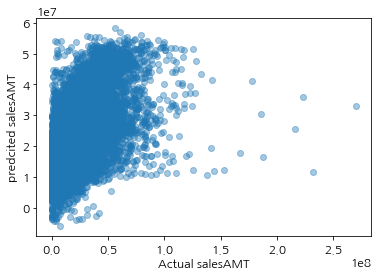

In [51]:
import matplotlib.pyplot as plt
plt.autoscale(enable=True)

plt.scatter(y_test,y_predict, alpha=0.4)
plt.xlabel('Actual salesAMT')
plt.ylabel('predcited salesAMT')
plt.show()

https://mindscale.kr/course/python-visualization-basic/grid

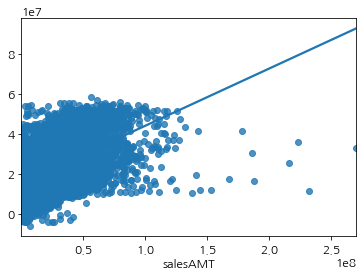

In [52]:
import seaborn as sns
sns.regplot(y_test,y_predict,ci=True)#신뢰구간

In [53]:
mlf.intercept_

array([6.62416216e+08])

In [54]:
mlf.coef_

array([[ 6.90487738e+05, -7.74631781e+03,  1.11523441e+04,
         4.12931124e+05,  2.82289215e+05,  8.49312278e+07,
        -3.08459226e+06,  1.67007534e+07,  3.14467663e+07,
         6.50752600e+06,  1.61256170e+07,  1.42456178e+07,
         2.68556237e+07,  4.84868035e+06,  8.86416946e+06,
        -1.43840159e+06, -5.47760970e+05,  3.49955081e+05,
         1.51266682e+05,  1.59702676e+05,  2.84423284e+06,
         4.03182236e+06,  8.60544140e+05]])

[groupby object를 dataframe으로](https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe)

In [55]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## decisiontreeregressor

In [56]:
from sklearn import tree
clf=tree.DecisionTreeRegressor()
clf=clf.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)

In [57]:
print('predicted:',y_pred.shape,'y_test:',y_test.shape)

predicted: (11212,) y_test: (11212, 1)


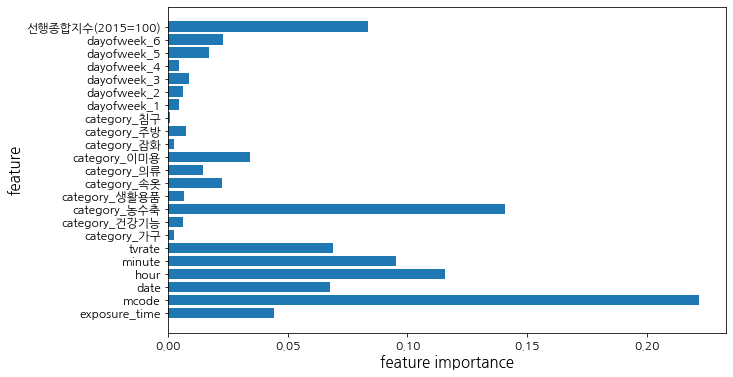

In [58]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

important=clf.feature_importances_

plt.barh(idx,important,align='center')
plt.yticks(idx)
plt.xlabel('feature importance',size=15)
plt.ylabel('feature',size=15)
plt.show()

In [59]:
model_score = mape(y_test['salesAMT'],y_pred)
print(model_score)

823.499114674424


## randomforestregressor
[randomforestregressor
](https://wikidocs.net/26294)

In [60]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

##########모델 학습

rf.fit(X_train, y_train)

##########모델 검증

print(rf.score(X_train, y_train))

print(rf.score(X_test, y_test)) 

##########모델 예측
y_pred2 = rf.predict(X_test)


C:\Users\user\anaconda3\envs\pytest\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.872420337392988
0.5780675915582879


In [61]:
model_score = mape(y_test['salesAMT'],y_pred2)
print(model_score)

843.594755218888


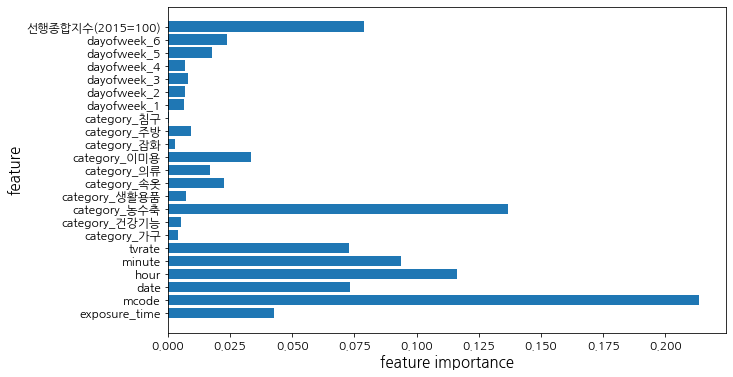

In [62]:
import numpy as np
import matplotlib.pyplot as plt

important=rf.feature_importances_
plt.rcParams["figure.figsize"] = (10,6)

plt.barh(idx,important,align='center')
plt.yticks(idx)
plt.xlabel('feature importance',size=15)
plt.ylabel('feature',size=15)
plt.show()